# PERSONALIZED CANCER DIAGNOSIS

## **Problem Statement :**
###Classify the given genetic variations/mutations based on evidence from text-based clinical literature.

## **Objective:**
###Predict the probability of each data-point belonging to each of the nine classes.

## **Constraints:**
### Interpretability 
### Class probabilities are needed. 
### Penalize the errors in class probabilites => Metric is Log-loss.
### No Latency constraints.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
import numpy as np
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os

In [2]:
from google.colab import drive 

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## READ THE TRAINING VARIANTS DATA

In [3]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Personalized Cancer Diagnosis/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


training/training_variants is a comma separated file containing the description of the genetic mutations used for training.
Fields are



1.   ID : the id of the row used to link the mutation to the clinical evidence
2.   Gene : the gene where this genetic mutation is located
3.   Variation : the aminoacid change for this mutations
4.   Class : 1-9 the class this genetic mutation has been classified on





## READ THE TEXT DATA

In [4]:
data_text =pd.read_csv("/content/drive/My Drive/Colab Notebooks/Personalized Cancer Diagnosis/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
stop_words = set(stopwords.words('english'))

## APPLY NLP PREPROCESSING TASK 

In [0]:
def nlp_preprocessing(total_text,index,column):  
  if type(total_text) is not int:
    string = ""

    # REPLACE EVERY SPECIAL CHARACTER WITH THE SPACE
    total_text=re.sub('[^a-zA-Z0-9\n]',' ',total_text)  

    # REPLACE MULTIPLE SPACES WITH SINGLE SPACE
    total_text=re.sub('\s+',' ', total_text)

    # CONVERT ALL THE CHARACTER TO LOWER CASE
    total_text=total_text.lower()

    for word in total_text.split() :
      if not word in stop_words:    # IF THE WORD IS NOT STOP WORD THEN RETAIN THAT WORD AND ASSINGN IN STRING VARIABLE
        string+=word + " "
    data_text[column][index] = string

In [8]:
start_time = time.clock()

for index,row in data_text.iterrows():
  if type(row['TEXT']) is str:
    nlp_preprocessing(row['TEXT'],index,'TEXT')
  else:
    print('There is no text description for id :',index)
print('Time : ',time.clock() - start_time,"seconds")

There is no text description for id : 1109
There is no text description for id : 1277
There is no text description for id : 1407
There is no text description for id : 1639
There is no text description for id : 2755
Time :  29.239386999999997 seconds


In [9]:
# MERGE THE DATA (GENE AND VARIATIONS) & TEXT DATA BASED ON THE ID
final_data = pd.merge(data,data_text,on='ID',how='left')

final_data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [10]:
final_data[final_data.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [0]:
final_data.loc[final_data['TEXT'].isnull(),'TEXT'] = final_data['Gene'] +' '+final_data['Variation']

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


Y_Class=final_data['Class'].values
final_data.Gene=final_data.Gene.str.replace('\s+','_')
final_data.Variation=final_data.Variation.str.replace('\s+','_')

# SPLIT THE DATA INTO TEST,TRAIN AND CV
X_1,X_Test,Y_1,Y_Test=train_test_split(final_data,Y_Class,stratify=Y_Class,test_size=0.2)
X_Train,X_CV,Y_Train,Y_CV=train_test_split(X_1,Y_1,test_size=0.2)

In [0]:
print('Number of data points in train data:', X_Train.shape[0])
print('Number of data points in test data:', X_Train.shape[0])
print('Number of data points in cross validation data:', X_CV.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 2124
Number of data points in cross validation data: 532


In [0]:
def plot_confusion_matrix(test_y,predict_y):
  C = confusion_matrix(test_y,predict_y)

  A=(((C.T)/(C.sum(axis=1))).T)

  B = (C/C.sum(axis=0))

  labels = [1,2,3,4,5,6,7,8,9]

  print("-"*20,"Confusion Matrix","-"*20)
  plt.figure(figsize = (20,7))

  sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()

  print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()

  print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()

Log Loss on CV using Random Model 2.4338510975006904
Log Loss on CV using Random Model 2.4719389345050624
-------------------- Confusion Matrix --------------------


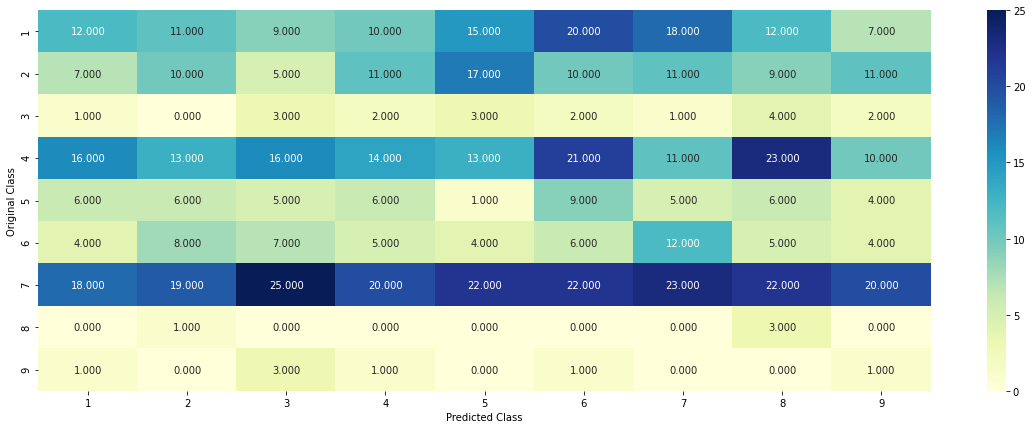

-------------------- Precision matrix (Columm Sum=1) --------------------


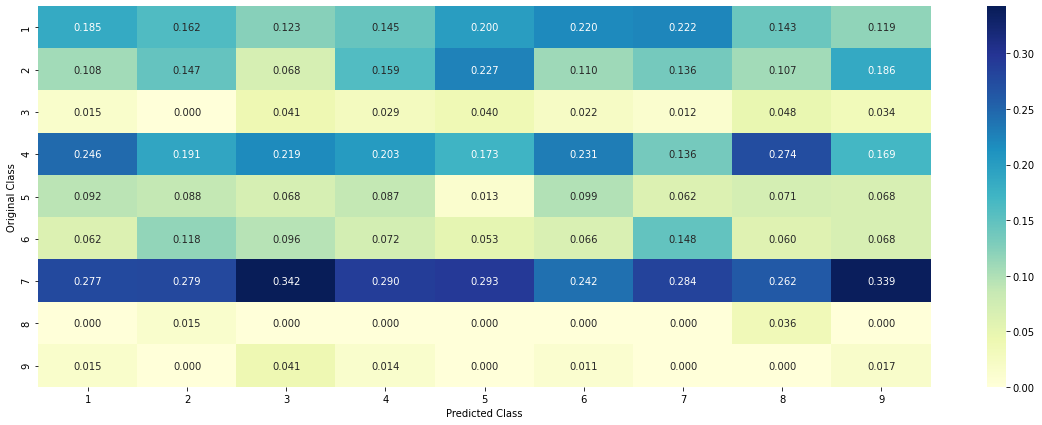

-------------------- Recall matrix (Row sum=1) --------------------


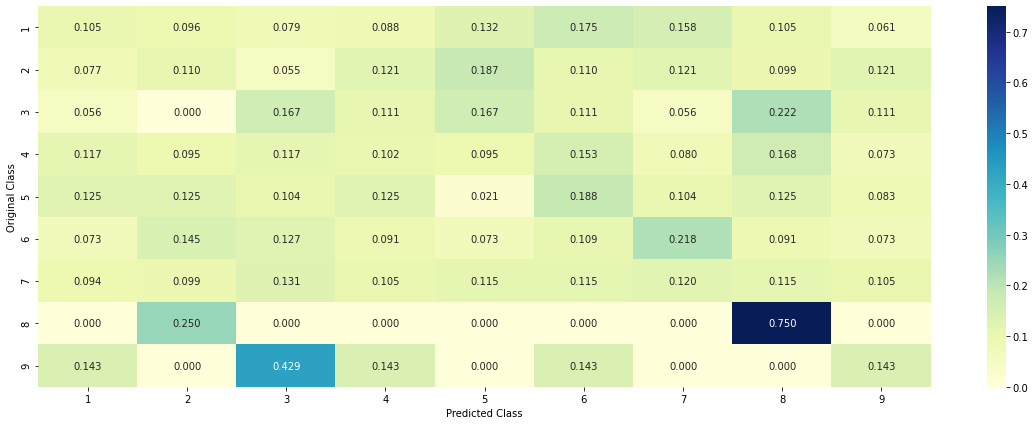

In [0]:
from sklearn.metrics import log_loss
import seaborn as sns
X_Test_len = X_Test.shape[0]
X_CV_len = X_CV.shape[0]

Y_CV_Predicted = np.zeros((X_CV_len,9))

for i in range(X_CV_len):
  rand_probs=np.random.rand(1,9)
  Y_CV_Predicted[i] =((rand_probs/sum(sum(rand_probs)))[0])
print("Log Loss on CV using Random Model",log_loss(Y_CV, Y_CV_Predicted,eps=1e-15))


Y_Test_Predicted = np.zeros((X_Test_len,9))

for i in range(X_Test_len ):
  rand_probs=np.random.rand(1,9)
  Y_Test_Predicted[i] =((rand_probs/sum(sum(rand_probs)))[0])
print("Log Loss on CV using Random Model",log_loss(Y_Test, Y_Test_Predicted,eps=1e-15))

predicted_y =np.argmax(Y_Test_Predicted, axis=1)
plot_confusion_matrix(Y_Test, predicted_y+1)

#UNIVARIATE ANALYSIS

In [0]:
def get_gene_variation_feature_dic(alpha,feature,df):
  
  value_count=df[feature].value_counts()
  print("Value Count :", value_count)
  gene_var = dict()

  for i,denominator in value_count.items():
    vec=[]

    for k in range(1,10):
      class_count=df.loc[(df['Class'] == k) & (df[feature] == i)]
      vec.append((class_count.shape[0] + alpha*10)/ (denominator + 90*alpha))   #Laplace Smoothing
    gene_var[i]=vec
  return gene_var

In [0]:
def get_gene_variation_features(alpha,feature,df):

  gv_dict=get_gene_variation_feature_dic(alpha,feature,df)

  value_count=df[feature].value_counts()

  gv_fea=[]
  print("DF Iteration_rows", df.iterrows())
  for index,row in df.iterrows():
    if row[feature] in dict(value_count).keys():
      gv_fea.append(gv_dict[row[feature]])
    else:
      gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
  return gv_fea

## Univariate Analysis on Gene Features

In [0]:
unique_genes=X_Train['Gene'].value_counts()

print("Number of Unique Genes :",unique_genes.shape[0])

print(unique_genes.head(10))

Number of Unique Genes : 231
BRCA1     159
TP53      103
EGFR       93
BRCA2      86
PTEN       84
KIT        72
BRAF       61
ERBB2      49
ALK        45
PDGFRA     38
Name: Gene, dtype: int64


### Looking at the count , looks like there are 236 different categories of Gene thats are in Training Data

### Distribution are as follows

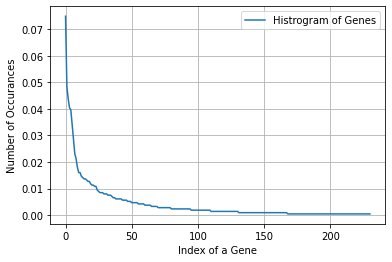

In [0]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

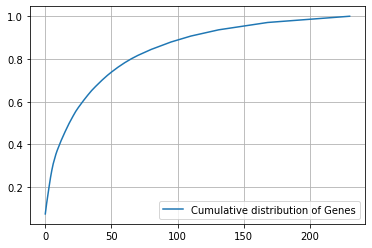

In [0]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

#### There are 2 ways we can featurize this variable.



1.   One Hot Encoding 
2.   Response Coding

We will choose the appropriate featurization based on the ML model we use.



# BAG OF WORDS VECTORIZATION TECHNIQUE 

### Response Coding Method on Gene Feature

In [0]:
alpha = 1 

X_Train_gene_Feature_responsecoding = np.array(get_gene_variation_features(alpha,"Gene",X_Train))
print("Train Gene Feature :",X_Train_gene_Feature_responsecoding.shape)

print("="*100)

X_Test_gen_Feature_responsecoding = np.array(get_gene_variation_features(alpha,"Gene",X_Test))
print("Test Gene Feature :",X_Test_gen_Feature_responsecoding.shape)

print("="*100)

X_CV_gene_Feature_responsecoding = np.array(get_gene_variation_features(alpha,"Gene",X_CV))
print("CV Gene Feature :",X_CV_gene_Feature_responsecoding.shape)

print("="*100)

Value Count : BRCA1     159
TP53      103
EGFR       93
BRCA2      86
PTEN       84
         ... 
ARID1B      1
WHSC1       1
ATRX        1
CDK8        1
CCND2       1
Name: Gene, Length: 231, dtype: int64
DF Iteration_rows <generator object DataFrame.iterrows at 0x7fd82baa7308>
Train Gene Feature : (2124, 9)
Value Count : BRCA1     56
TP53      34
EGFR      31
PTEN      25
BRAF      19
          ..
MPL        1
CDK12      1
FAM58A     1
ETV6       1
PMS1       1
Name: Gene, Length: 162, dtype: int64
DF Iteration_rows <generator object DataFrame.iterrows at 0x7fd82baa7308>
Test Gene Feature : (665, 9)
Value Count : BRCA1      49
TP53       26
BRCA2      21
EGFR       17
PTEN       17
           ..
CDKN1A      1
TMPRSS2     1
SRC         1
BCL10       1
PMS2        1
Name: Gene, Length: 138, dtype: int64
DF Iteration_rows <generator object DataFrame.iterrows at 0x7fd82baa7308>
CV Gene Feature : (532, 9)


### One Hot Encoding Method on Gene feature

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
gene_vectorizer=CountVectorizer()

X_Train_gene_Feature_onehotEncoding=gene_vectorizer.fit_transform(X_Train["Gene"])
print(" Train Gene Feature :" ,X_Train_gene_Feature_onehotEncoding.shape)

print("="*100)

X_Test_gene_Feature_onehotencoding=gene_vectorizer.transform(X_Test["Gene"])
print(" Test Gene Feature :" ,X_Test_gene_Feature_onehotencoding.shape)

print("="*100)


X_CV_gene_Feature_onehotencoding=gene_vectorizer.transform(X_CV["Gene"])
print(" CV Gene Feature :" ,X_CV_gene_Feature_onehotencoding.shape)

print("="*100)

 Train Gene Feature : (2124, 231)
 Test Gene Feature : (665, 231)
 CV Gene Feature : (532, 231)


### APPLY SVM -->  SGD CLASSIFIER TO FIND THE BEST HYPERPARAMETER

For values of alpha =  1e-05 The log loss is: 1.2166022018727414
For values of alpha =  0.0001 The log loss is: 1.2015674070771591
For values of alpha =  0.001 The log loss is: 1.2551213383409736
For values of alpha =  0.01 The log loss is: 1.3804867072117146
For values of alpha =  0.1 The log loss is: 1.468121389285184
For values of alpha =  1 The log loss is: 1.500584489952845


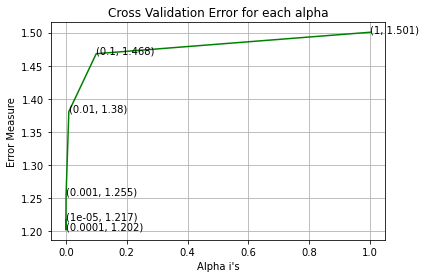

For values of best alpha =  0.0001 The train log loss is: 0.9882420694256845
For values of best alpha =  0.0001 The cross validation log loss is: 1.2015674070771591
For values of best alpha =  0.0001 The test log loss is: 1.1981102682844584


In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error=[]

for i in alpha :
  clf=SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
  clf.fit(X_Train_gene_Feature_onehotEncoding,Y_Train)
  sig_clf=CalibratedClassifierCV(clf,method="sigmoid")
  sig_clf.fit(X_Train_gene_Feature_onehotEncoding,Y_Train)
  Predicted_Y=sig_clf.predict_proba(X_CV_gene_Feature_onehotencoding)
  cv_log_error.append(log_loss(Y_CV,Predicted_Y,labels=clf.classes_,eps=1e-15))
  print('For values of alpha = ', i, "The log loss is:",log_loss(Y_CV, Predicted_Y, labels=clf.classes_, eps=1e-15))

fig,ax = plt.subplots()
ax.plot(alpha,cv_log_error,c='g')

for i , txt in enumerate(np.round(cv_log_error,3)):
  ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_Train_gene_Feature_onehotEncoding, Y_Train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_Train_gene_Feature_onehotEncoding, Y_Train)

predict_y = sig_clf.predict_proba(X_Train_gene_Feature_onehotEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_Train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_CV_gene_Feature_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_Test_gene_Feature_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))

In [0]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=X_Test[X_Test['Gene'].isin(list(set(X_Train['Gene'])))].shape[0]
cv_coverage=X_CV[X_CV['Gene'].isin(list(set(X_Train['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',X_Test.shape[0], ":",(test_coverage/X_Test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',X_CV.shape[0],":" ,(cv_coverage/X_CV.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  231  genes in train dataset?
Ans
1. In test data 645 out of 665 : 96.99248120300751
2. In cross validation data 514 out of  532 : 96.61654135338345


## Univariate Analysis on Variation Features

In [0]:
unique_variations=X_Train['Variation'].value_counts()

print("Number of Unique Genes :",unique_variations.shape[0])

print(unique_variations.head(10))

Number of Unique Genes : 1929
Truncating_Mutations         60
Deletion                     48
Amplification                41
Fusions                      18
Overexpression                4
Q61L                          3
G12V                          3
R170W                         2
Q61H                          2
Promoter_Hypermethylation     2
Name: Variation, dtype: int64


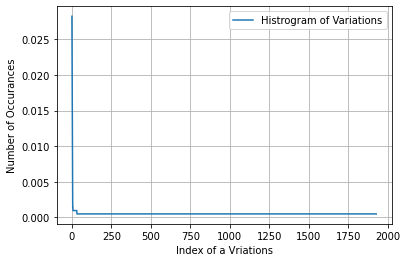

In [0]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Vriations')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02824859 0.05084746 0.07015066 ... 0.99905838 0.99952919 1.        ]


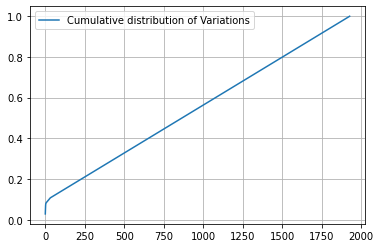

In [0]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

#### There are 2 ways we can featurize this variable.



1.   One Hot Encoding 
2.   Response Coding

We will choose the appropriate featurization based on the ML model we use.

### Response Coding Method on Variation Features

In [0]:
alpha = 1 

X_Train_variation_Feature_responsecoding = np.array(get_gene_variation_features(alpha,"Variation",X_Train))
print("Train Variation Feature :",X_Train_variation_Feature_responsecoding.shape)

print("="*100)

X_Test_variation_Feature_responsecoding = np.array(get_gene_variation_features(alpha,"Variation",X_Test))
print("Test Variation Feature :",X_Test_variation_Feature_responsecoding.shape)

print("="*100)

X_CV_variation_Feature_responsecoding = np.array(get_gene_variation_features(alpha,"Variation",X_CV))
print("CV Variation Feature :",X_CV_variation_Feature_responsecoding.shape)

print("="*100)

Value Count : Truncating_Mutations    60
Deletion                48
Amplification           41
Fusions                 18
Overexpression           4
                        ..
L122R                    1
T34_A289del              1
EWSR1-FLI1_Fusion        1
C2060G                   1
P287A                    1
Name: Variation, Length: 1929, dtype: int64
DF Iteration_rows <generator object DataFrame.iterrows at 0x7fd826c7e7d8>
Train Variation Feature : (2124, 9)
Value Count : Deletion                16
Truncating_Mutations    16
Amplification           14
Fusions                 11
Q61R                     2
                        ..
A1131T                   1
K590R                    1
G1803A                   1
P1859R                   1
E462G                    1
Name: Variation, Length: 611, dtype: int64
DF Iteration_rows <generator object DataFrame.iterrows at 0x7fd826c7e7d8>
Test Variation Feature : (665, 9)
Value Count : Truncating_Mutations    17
Amplification           16
Delet

### One Hot Encoding on Variation Feature

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
variation_vectorizer=CountVectorizer()

X_Train_variation_Feature_onehotEncoding=variation_vectorizer.fit_transform(X_Train["Variation"])
print(" Train Variation Feature :" ,X_Train_variation_Feature_onehotEncoding.shape)

print("="*100)

X_Test_variation_Feature_onehotencoding=variation_vectorizer.transform(X_Test["Variation"])
print(" Test Variation Feature :" ,X_Test_variation_Feature_onehotencoding.shape)

print("="*100)


X_CV_variation_Feature_onehotencoding=variation_vectorizer.transform(X_CV["Variation"])
print(" CV Variation Feature :" ,X_CV_variation_Feature_onehotencoding.shape)

print("="*100)

 Train Variation Feature : (2124, 1956)
 Test Variation Feature : (665, 1956)
 CV Variation Feature : (532, 1956)


### APPLY SVM -->  SGD CLASSIFIER TO FIND THE BEST HYPERPARAMETER

For values of alpha =  1e-05 The log loss is: 1.7368916556958085
For values of alpha =  0.0001 The log loss is: 1.7305804509088687
For values of alpha =  0.001 The log loss is: 1.7269911213724305
For values of alpha =  0.01 The log loss is: 1.731115111931615
For values of alpha =  0.1 The log loss is: 1.7407613800259418
For values of alpha =  1 The log loss is: 1.7434113605325594


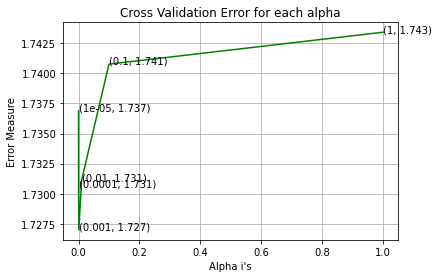

For values of best alpha =  0.001 The train log loss is: 1.0374898189029886
For values of best alpha =  0.001 The cross validation log loss is: 1.7269911213724305
For values of best alpha =  0.001 The test log loss is: 1.704806332912111


In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error=[]

for i in alpha :
  clf=SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
  clf.fit(X_Train_variation_Feature_onehotEncoding,Y_Train)
  sig_clf=CalibratedClassifierCV(clf,method="sigmoid")
  sig_clf.fit(X_Train_variation_Feature_onehotEncoding,Y_Train)
  Predicted_Y=sig_clf.predict_proba(X_CV_variation_Feature_onehotencoding)
  cv_log_error.append(log_loss(Y_CV,Predicted_Y,labels=clf.classes_,eps=1e-15))
  print('For values of alpha = ', i, "The log loss is:",log_loss(Y_CV, Predicted_Y, labels=clf.classes_, eps=1e-15))

fig,ax = plt.subplots()
ax.plot(alpha,cv_log_error,c='g')

for i , txt in enumerate(np.round(cv_log_error,3)):
  ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_Train_variation_Feature_onehotEncoding, Y_Train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_Train_variation_Feature_onehotEncoding, Y_Train)

predict_y = sig_clf.predict_proba(X_Train_variation_Feature_onehotEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_Train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_CV_variation_Feature_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_Test_variation_Feature_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))

In [0]:
test_coverage=X_Test[X_Test['Variation'].isin(list(set(X_Train['Variation'])))].shape[0]
cv_coverage=X_CV[X_CV['Variation'].isin(list(set(X_Train['Variation'])))].shape[0]

print('1. In test data',test_coverage, 'out of',X_Test.shape[0], ":",(test_coverage/X_Test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',X_CV.shape[0],":" ,(cv_coverage/X_CV.shape[0])*100)

1. In test data 66 out of 665 : 9.924812030075188
2. In cross validation data 59 out of  532 : 11.090225563909774


## Univariate Analysis on Text Features

In [0]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [0]:
import math

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

### One Hot Encoding on Text Feature

In [0]:
text_vectorizer = CountVectorizer(min_df=3)
X_Train_feature_onehotCoding = text_vectorizer.fit_transform(X_Train['TEXT'])
# getting all the feature names (words)
X_Train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = X_Train_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(X_Train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(X_Train_text_features))

Total number of unique words in train data : 52882


In [0]:
from collections import defaultdict
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = X_Train[X_Train['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list


total_dict = extract_dictionary_paddle(X_Train)


confuse_array = []
for i in X_Train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

Response Coding on Text Feature

In [0]:
X_Train_text_feature_responseCoding  = get_text_responsecoding(X_Train)
print("Train Text Feature :", X_Train_text_feature_responseCoding.shape)

print("="*100)

X_Test_text_feature_responseCoding  = get_text_responsecoding(X_Test)
print("Test Text Feature :", X_Test_text_feature_responseCoding.shape)

print("="*100)
X_CV_text_feature_responseCoding  = get_text_responsecoding(X_CV)
print("CV Text Feature :", X_CV_text_feature_responseCoding.shape)

print("="*100)

Train Text Feature : (2124, 9)
Test Text Feature : (665, 9)
CV Text Feature : (532, 9)


In [0]:
X_Train_text_feature_responseCoding = (X_Train_text_feature_responseCoding.T/X_Train_text_feature_responseCoding.sum(axis=1)).T
X_Test_text_feature_responseCoding = (X_Test_text_feature_responseCoding.T/X_Test_text_feature_responseCoding.sum(axis=1)).T
X_CV_text_feature_responseCoding = (X_CV_text_feature_responseCoding.T/X_CV_text_feature_responseCoding.sum(axis=1)).T

### Normalize the features

In [0]:
from sklearn.preprocessing import normalize

X_Train_feature_onehotCoding = normalize(X_Train_feature_onehotCoding, axis=0)
print("Train Text Feature :", X_Train_feature_onehotCoding.shape)

print("="*100)

X_Test_text_feature_onehotCoding = text_vectorizer.transform(X_Test['TEXT'])
print("Test Text Feature :", X_Test_text_feature_onehotCoding.shape)

print("="*100)

X_Test_text_feature_onehotCoding = normalize(X_Test_text_feature_onehotCoding, axis=0)

X_CV_text_feature_onehotCoding = text_vectorizer.transform(X_CV['TEXT'])
print("CV Text Feature :", X_CV_text_feature_onehotCoding.shape)

print("="*100)

X_CV_text_feature_onehotCoding = normalize(X_CV_text_feature_onehotCoding, axis=0)

Train Text Feature : (2124, 52882)
Test Text Feature : (665, 52882)
CV Text Feature : (532, 52882)


In [0]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values())) 

### APPLY SVM -->  SGD CLASSIFIER TO FIND THE BEST HYPERPARAMETER

For values of alpha =  1e-05 The log loss is: 1.2813491064466804
For values of alpha =  0.0001 The log loss is: 1.1531172509122398
For values of alpha =  0.001 The log loss is: 1.1393878819557273
For values of alpha =  0.01 The log loss is: 1.2716465329687872
For values of alpha =  0.1 The log loss is: 1.4686398010742088
For values of alpha =  1 The log loss is: 1.6626389802062658


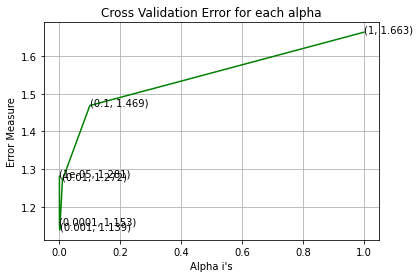

For values of best alpha =  0.001 The train log loss is: 0.6707611555373096
For values of best alpha =  0.001 The cross validation log loss is: 1.1393878819557273
For values of best alpha =  0.001 The test log loss is: 1.1973462821831873


In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error=[]

for i in alpha :
  clf=SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
  clf.fit(X_Train_feature_onehotCoding,Y_Train)
  sig_clf=CalibratedClassifierCV(clf,method="sigmoid")
  sig_clf.fit(X_Train_feature_onehotCoding,Y_Train)
  Predicted_Y=sig_clf.predict_proba(X_CV_text_feature_onehotCoding)
  cv_log_error.append(log_loss(Y_CV,Predicted_Y,labels=clf.classes_,eps=1e-15))
  print('For values of alpha = ', i, "The log loss is:",log_loss(Y_CV, Predicted_Y, labels=clf.classes_, eps=1e-15))

fig,ax = plt.subplots()
ax.plot(alpha,cv_log_error,c='g')

for i , txt in enumerate(np.round(cv_log_error,3)):
  ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_Train_feature_onehotCoding, Y_Train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_Train_feature_onehotCoding, Y_Train)

predict_y = sig_clf.predict_proba(X_Train_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_Train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_CV_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_Test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))

## BUILDING A MACHINE LEARNING MODELS

In [0]:
def predict_and_plot_confusionmatrix(X_train,Y_train,X_test,Y_test,clf):
  clf.fit(X_train,Y_train)
  sig_clf=CalibratedClassifierCV(clf,method="sigmoid")
  sig_clf.fit(X_train,Y_train)
  pred_y=sig_clf.predict(X_test)


  print("Log Loss : ",log_loss(Y_test,sig_clf.predict_proba(X_test)))
  print("Number of Misclassified Points :",np.count_nonzero((pred_y - Y_test))/Y_test.shape[0])

  plot_confusion_matrix(Y_test,pred_y)

In [0]:
def report_log_loss(X_train,Y_train,X_test,Y_test,clf):
  clf.fit(X_Train,Y_train)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(X_train,Y_train)
  sig_clf_probs=sig_clf.predict_proba(X_Test)
  return log_loss(Y_Test, sig_clf_probs, eps=1e-15)

## Get Feature Names 

In [0]:
def get_impfeature_names_tfidf(indices, text, gene, var, no_features):
    gene_count_vec = TfidfVectorizer()
    var_count_vec = TfidfVectorizer()
    text_count_vec = TfidfVectorizer(min_df=3)
    print ("Hello")
    gene_vec = gene_count_vec.fit(X_Train['Gene'])
    var_vec  = var_count_vec.fit(X_Train['Variation'])
    text_vec = text_count_vec.fit(X_Train['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

## STACKING THE THREE TYPES OF FEATURES

In [0]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import normalize
from collections import defaultdict
import math
from sklearn.metrics import log_loss
import seaborn as sns

In [0]:
X_Train_gene_var_onehotcoding = hstack((X_Train_gene_Feature_onehotEncoding,X_Train_variation_Feature_onehotEncoding))
X_Test_gene_var_onehotcoding =  hstack((X_Test_gene_Feature_onehotencoding,X_Test_variation_Feature_onehotencoding))
X_CV_gene_var_onehotcoding = hstack((X_CV_gene_Feature_onehotencoding,X_CV_variation_Feature_onehotencoding))

X_Train_onehotCoding = hstack((X_Train_gene_var_onehotcoding,X_Train_feature_onehotCoding)).tocsr()
print("Train One Hot Encoding  :", X_Train_onehotCoding.shape)
print("="*100)

X_Test_onehotcoding = hstack((X_Test_gene_var_onehotcoding,X_Test_text_feature_onehotCoding))
print("Test One Hot Encoding  :", X_Test_onehotcoding.shape)
print("="*100)

X_CV_onehotcoding = hstack((X_CV_gene_var_onehotcoding,X_CV_text_feature_onehotCoding))
print("CV One Hot Encoding  :", X_CV_onehotcoding.shape)
print("="*100)


X_Train_gene_var_responseCoding = np.hstack((X_Train_gene_Feature_responsecoding,X_Train_variation_Feature_responsecoding))
X_Test_gene_var_responseCoding = np.hstack((X_Test_gen_Feature_responsecoding,X_Test_variation_Feature_responsecoding))
X_CV_gene_var_responseCoding = np.hstack((X_CV_gene_Feature_responsecoding,X_CV_variation_Feature_responsecoding))

X_Train_responseCoding = np.hstack((X_Train_gene_var_responseCoding, X_Train_text_feature_responseCoding))
print("Train Response Coding  :", X_Train_responseCoding.shape)
print("="*100)

X_Test_responseCoding = np.hstack((X_Test_gene_var_responseCoding, X_Test_text_feature_responseCoding))
print("Test Response Coding  :", X_Test_responseCoding.shape)
print("="*100)
X_CV_responseCoding = np.hstack((X_CV_gene_var_responseCoding, X_CV_text_feature_responseCoding))
print("CV Response Coding  :", X_CV_responseCoding.shape)
print("="*100)

Train One Hot Encoding  : (2124, 55069)
Test One Hot Encoding  : (665, 55069)
CV One Hot Encoding  : (532, 55069)
Train Response Coding  : (2124, 27)
Test Response Coding  : (665, 27)
CV Response Coding  : (532, 27)


# BASE LINE MODEL

## NAIVE BAYES ALGORITHM

In [0]:
def Naive_Bayes_Algo(X_Train,Y_Train,X_CV,Y_CV,X_Test,Y_Test):

  alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
  cv_log_error=[]

  for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(X_Train_onehotCoding,Y_Train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_Train_onehotCoding, Y_Train)
    sig_clf_probs = sig_clf.predict_proba(X_CV_onehotcoding)
    cv_log_error.append(log_loss(Y_CV, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(Y_CV, sig_clf_probs))

  fig, ax = plt.subplots()
  ax.plot(np.log10(alpha), cv_log_error,c='g')
  for i , txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error[i]))
  plt.grid()
  plt.xticks(np.log10(alpha))
  plt.title("Cross Validation Error for each alpha")
  plt.xlabel("Alpha i's")
  plt.ylabel("Error measure")
  plt.show()

  best_alpha = np.argmin(cv_log_error)
  clf = MultinomialNB(alpha=alpha[best_alpha])
  clf.fit(X_Train_onehotCoding, Y_Train)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(X_Train_onehotCoding, Y_Train)

  predict_y = sig_clf.predict_proba(X_Train_onehotCoding)
  print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_Train, predict_y, labels=clf.classes_, eps=1e-15))
  
  predict_y = sig_clf.predict_proba(X_CV_onehotcoding)
  print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))
  
  predict_y = sig_clf.predict_proba(X_Test_onehotcoding)
  print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))

  return alpha,best_alpha

for alpha = 1e-05
Log Loss : 1.3034930822041142
for alpha = 0.0001
Log Loss : 1.2920946891531988
for alpha = 0.001
Log Loss : 1.2829763040442763
for alpha = 0.1
Log Loss : 1.2641674889440229
for alpha = 1
Log Loss : 1.3141869830771657
for alpha = 10
Log Loss : 1.4284390667502438
for alpha = 100
Log Loss : 1.4093150526507667
for alpha = 1000
Log Loss : 1.3686625409125144


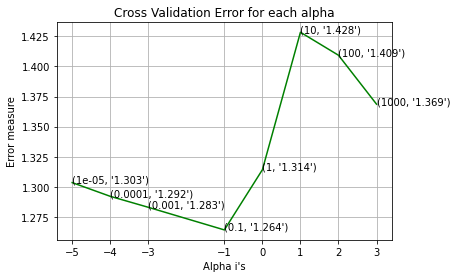

For values of best alpha =  0.1 The train log loss is: 0.8660693600901264
For values of best alpha =  0.1 The cross validation log loss is: 1.2641674889440229
For values of best alpha =  0.1 The test log loss is: 1.2557774713126642


In [0]:
alpha,best_alpha = Naive_Bayes_Algo(X_Train,Y_Train,X_CV,Y_CV,X_Test,Y_Test)

Log Loss : 1.2641674889440229
Number of missclassified point : 0.39285714285714285
-------------------- Confusion Matrix --------------------


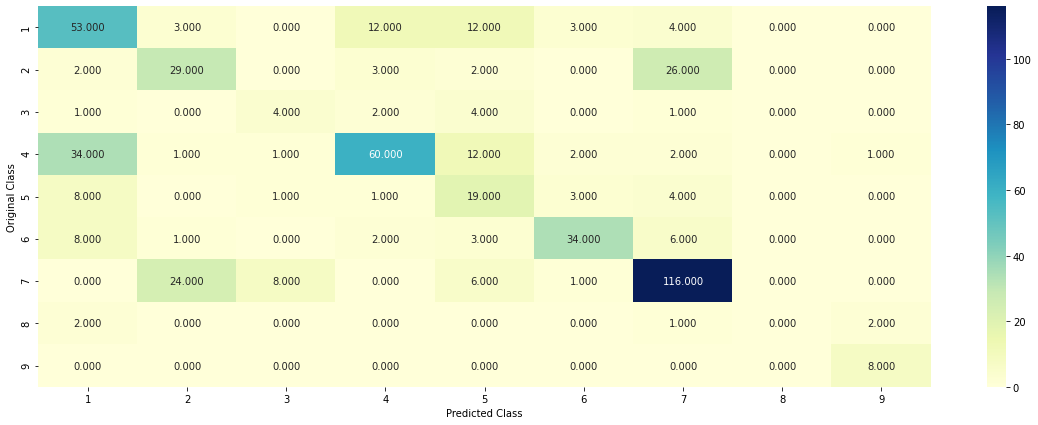

-------------------- Precision matrix (Columm Sum=1) --------------------


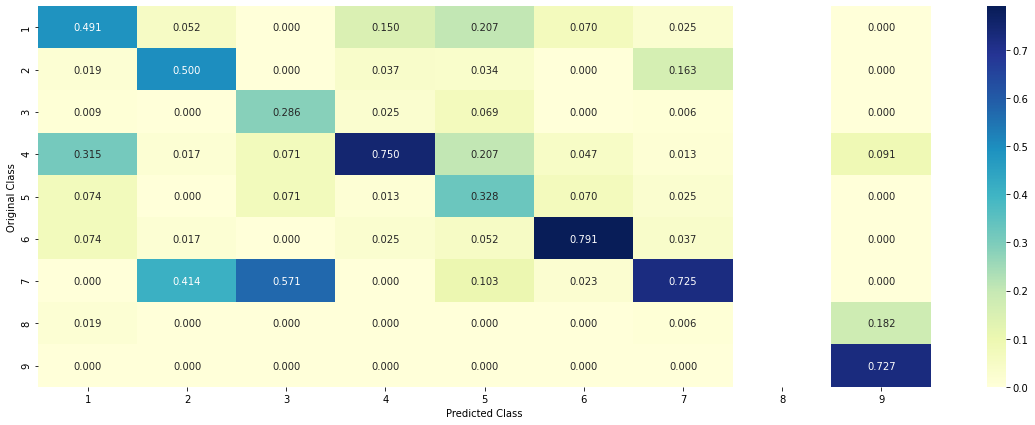

-------------------- Recall matrix (Row sum=1) --------------------


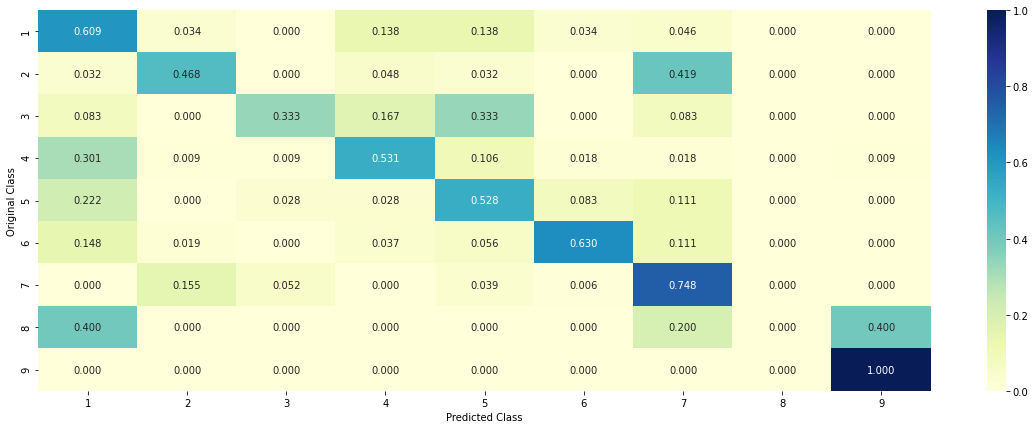

In [0]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(X_Train_onehotCoding, Y_Train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_Train_onehotCoding, Y_Train)
sig_clf_probs = sig_clf.predict_proba(X_CV_onehotcoding)

print("Log Loss :",log_loss(Y_CV, sig_clf_probs))

print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(X_CV_onehotcoding)- Y_CV))/Y_CV.shape[0])
plot_confusion_matrix(Y_CV, sig_clf.predict(X_CV_onehotcoding.toarray()))

## K-NEAREST NEIGHBORS ALGORITHM 

for alpha = 5
Log Loss : 1.2614914149842475
for alpha = 11
Log Loss : 1.2389090900755197
for alpha = 15
Log Loss : 1.3249904988624182
for alpha = 21
Log Loss : 1.4287538226862504
for alpha = 31
Log Loss : 1.48904891702007
for alpha = 41
Log Loss : 1.5252173098320099
for alpha = 51
Log Loss : 1.5319041425309257
for alpha = 99
Log Loss : 1.3966114619320464


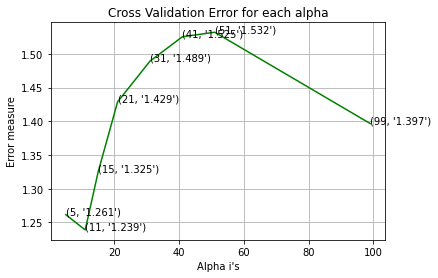

For values of best alpha =  11 The train log loss is: 1.0511464252575564
For values of best alpha =  11 The cross validation log loss is: 1.2389090900755197
For values of best alpha =  11 The test log loss is: 1.294191225391241


In [0]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_Train_onehotcoding_tfidf, Y_Train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_Train_onehotcoding_tfidf, Y_Train)
    sig_clf_probs = sig_clf.predict_proba(X_CV_onehotcoding_tfidf)
    cv_log_error_array.append(log_loss(Y_CV, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_CV, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(X_Train_onehotcoding_tfidf, Y_Train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_Train_onehotcoding_tfidf, Y_Train)

predict_y = sig_clf.predict_proba(X_Train_onehotcoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_Train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_CV_onehotcoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_Test_onehotcoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))

## LOGISTIC REGRESSION (WITH CLASS BALANCING)

In [0]:
def Logistic_Regression_Algo(X_Train,Y_Train,X_CV,Y_CV,X_Test,Y_Test):

  alpha = [10 ** x for x in range(-6, 3)]
  cv_log_error=[]

  for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_Train_onehotCoding,Y_Train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_Train_onehotCoding, Y_Train)
    sig_clf_probs = sig_clf.predict_proba(X_CV_onehotcoding)
    cv_log_error.append(log_loss(Y_CV, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(Y_CV, sig_clf_probs))

  fig, ax = plt.subplots()
  ax.plot(np.log10(alpha), cv_log_error,c='g')
  for i , txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error[i]))
  plt.grid()
  plt.xticks(np.log10(alpha))
  plt.title("Cross Validation Error for each alpha")
  plt.xlabel("Alpha i's")
  plt.ylabel("Error measure")
  plt.show()

  best_alpha = np.argmin(cv_log_error)
  clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
  clf.fit(X_Train_onehotCoding, Y_Train)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(X_Train_onehotCoding, Y_Train)

  predict_y = sig_clf.predict_proba(X_Train_onehotCoding)
  print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_Train, predict_y, labels=clf.classes_, eps=1e-15))
  
  predict_y = sig_clf.predict_proba(X_CV_onehotcoding)
  print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))
  
  predict_y = sig_clf.predict_proba(X_Test_onehotcoding)
  print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))

  return alpha,best_alpha

for alpha = 1e-06
Log Loss : 1.276900676011861
for alpha = 1e-05
Log Loss : 1.250903930900596
for alpha = 0.0001
Log Loss : 1.050985579516763
for alpha = 0.001
Log Loss : 1.032139775746308
for alpha = 0.01
Log Loss : 1.1514528964836173
for alpha = 0.1
Log Loss : 1.5221829941938771
for alpha = 1
Log Loss : 1.7579025778812853
for alpha = 10
Log Loss : 1.7830265597709112
for alpha = 100
Log Loss : 1.7855555877083482


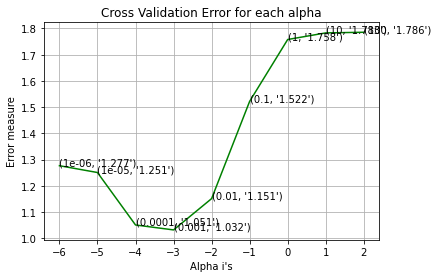

For values of best alpha =  0.001 The train log loss is: 0.5455117832038454
For values of best alpha =  0.001 The cross validation log loss is: 1.032139775746308
For values of best alpha =  0.001 The test log loss is: 1.1388152021630162


In [0]:
alpha,best_alpha = Logistic_Regression_Algo(X_Train,Y_Train,X_CV,Y_CV,X_Test,Y_Test)

Log Loss :  1.032139775746308
Number of Misclassified Points : 0.32706766917293234
-------------------- Confusion Matrix --------------------


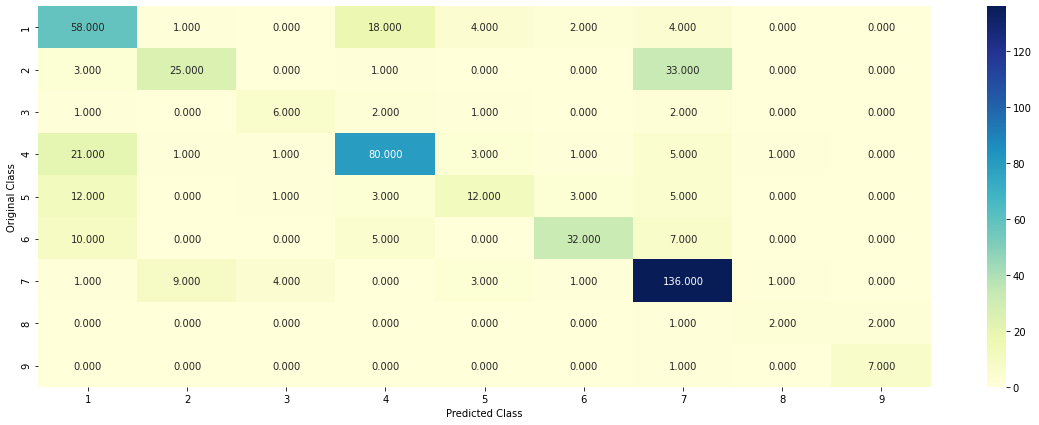

-------------------- Precision matrix (Columm Sum=1) --------------------


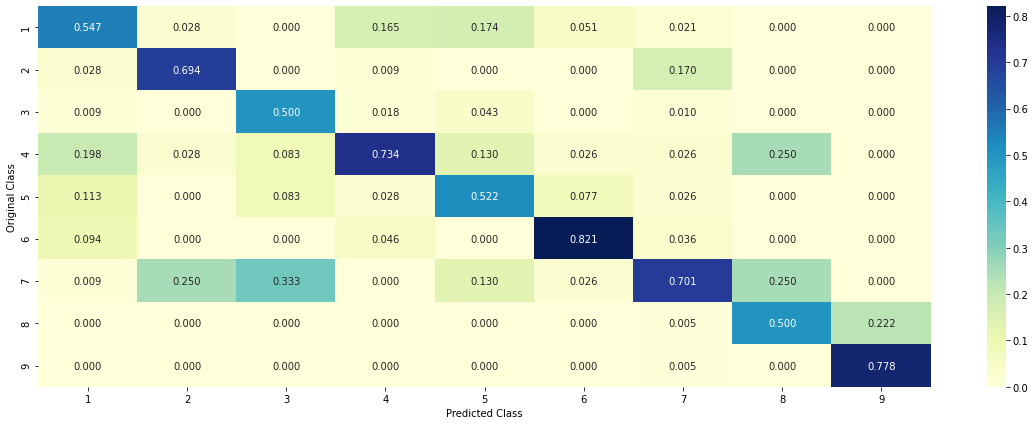

-------------------- Recall matrix (Row sum=1) --------------------


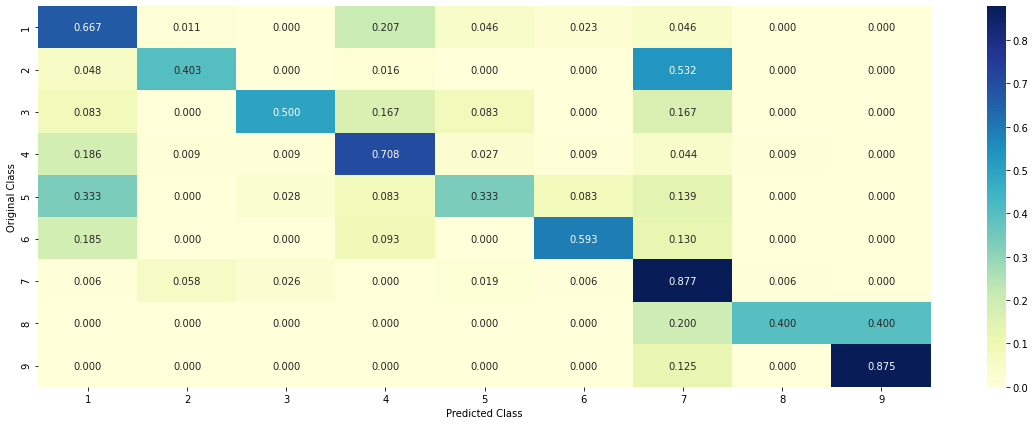

In [0]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusionmatrix(X_Train_onehotCoding, Y_Train, X_CV_onehotcoding, Y_CV, clf)

## LOGISTIC REGRESSION WITHOUT CLASS BALANCING 

In [0]:
def Logistic_Regression_Algo_WithoutClassBalancing(X_Train,Y_Train,X_CV,Y_CV,X_Test,Y_Test):

  alpha = [10 ** x for x in range(-6, 3)]
  cv_log_error=[]

  for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_Train_onehotCoding,Y_Train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_Train_onehotCoding, Y_Train)
    sig_clf_probs = sig_clf.predict_proba(X_CV_onehotcoding)
    cv_log_error.append(log_loss(Y_CV, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(Y_CV, sig_clf_probs))

  fig, ax = plt.subplots()
  ax.plot(np.log10(alpha), cv_log_error,c='g')
  for i , txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error[i]))
  plt.grid()
  plt.xticks(np.log10(alpha))
  plt.title("Cross Validation Error for each alpha")
  plt.xlabel("Alpha i's")
  plt.ylabel("Error measure")
  plt.show()

  best_alpha = np.argmin(cv_log_error)
  clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
  clf.fit(X_Train_onehotCoding, Y_Train)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(X_Train_onehotCoding, Y_Train)

  predict_y = sig_clf.predict_proba(X_Train_onehotCoding)
  print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_Train, predict_y, labels=clf.classes_, eps=1e-15))
  
  predict_y = sig_clf.predict_proba(X_CV_onehotcoding)
  print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))
  
  predict_y = sig_clf.predict_proba(X_Test_onehotcoding)
  print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))

  return alpha,best_alpha

for alpha = 1e-06
Log Loss : 1.2606893161007808
for alpha = 1e-05
Log Loss : 1.2491416252324874
for alpha = 0.0001
Log Loss : 1.0780781170529947
for alpha = 0.001
Log Loss : 1.0595769856106745
for alpha = 0.01
Log Loss : 1.1993025965473718
for alpha = 0.1
Log Loss : 1.398012568949945
for alpha = 1
Log Loss : 1.6042864028265824
for alpha = 10
Log Loss : 1.6454181760527766
for alpha = 100
Log Loss : 1.6499863249443145


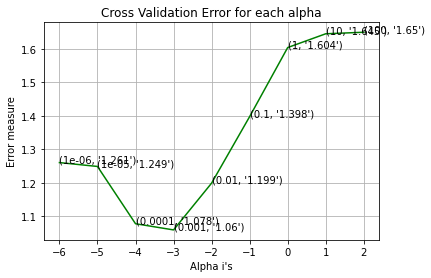

For values of best alpha =  0.001 The train log loss is: 0.5412378614861534
For values of best alpha =  0.001 The cross validation log loss is: 1.0595769856106745
For values of best alpha =  0.001 The test log loss is: 1.1477314784392156


In [0]:
alpha,best_alpha = Logistic_Regression_Algo_WithoutClassBalancing(X_Train,Y_Train,X_CV,Y_CV,X_Test,Y_Test)

Log Loss :  1.0595769856106745
Number of Misclassified Points : 0.32706766917293234
-------------------- Confusion Matrix --------------------


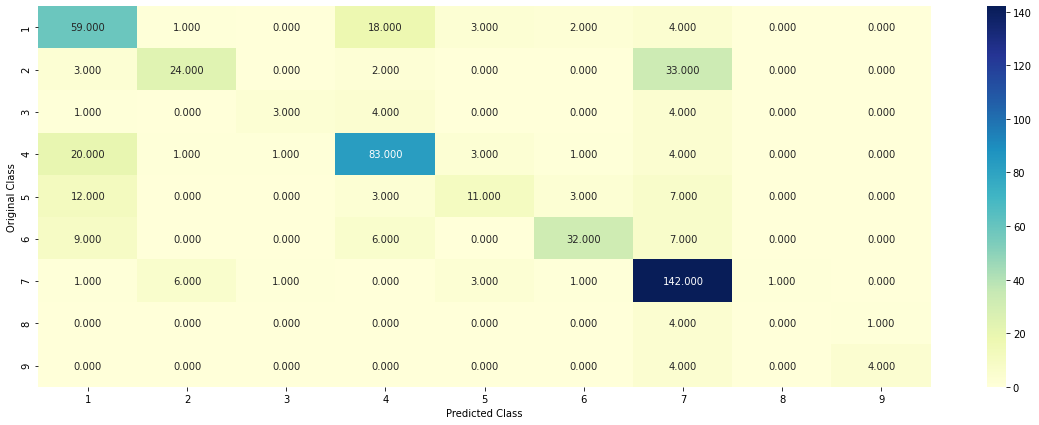

-------------------- Precision matrix (Columm Sum=1) --------------------


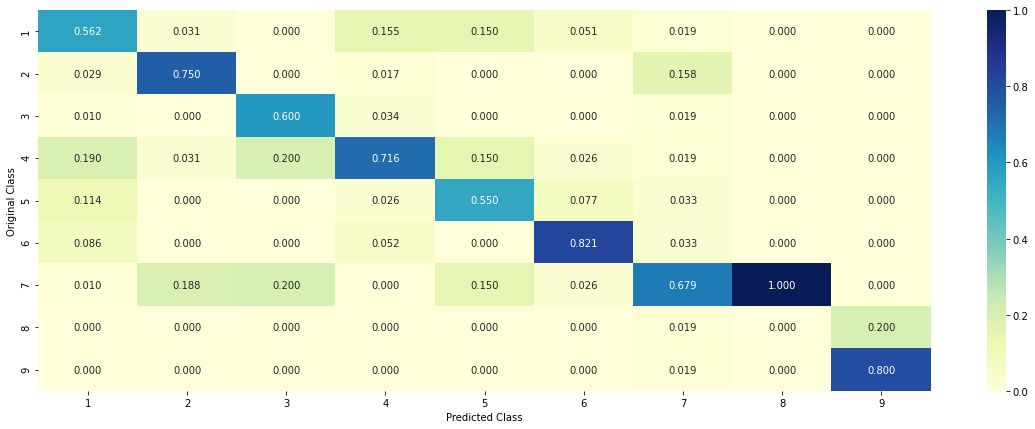

-------------------- Recall matrix (Row sum=1) --------------------


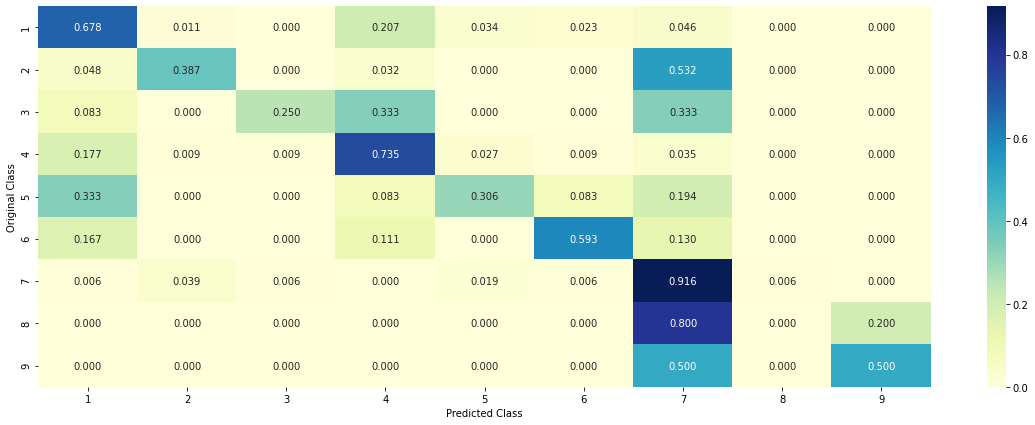

In [0]:
clf = SGDClassifier( alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusionmatrix(X_Train_onehotCoding, Y_Train, X_CV_onehotcoding, Y_CV, clf)

## LINEAR SUPPORT VECTOR MACHINE

In [0]:
def LinearSVM_Algo(X_Train,Y_Train,X_CV,Y_CV,X_Test,Y_Test):

  alpha = [10 ** x for x in range(-6, 3)]
  cv_log_error=[]

  for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_Train_onehotCoding,Y_Train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_Train_onehotCoding, Y_Train)
    sig_clf_probs = sig_clf.predict_proba(X_CV_onehotcoding)
    cv_log_error.append(log_loss(Y_CV, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(Y_CV, sig_clf_probs))

  fig, ax = plt.subplots()
  ax.plot(np.log10(alpha), cv_log_error,c='g')
  for i , txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error[i]))
  plt.grid()
  plt.xticks(np.log10(alpha))
  plt.title("Cross Validation Error for each alpha")
  plt.xlabel("Alpha i's")
  plt.ylabel("Error measure")
  plt.show()

  best_alpha = np.argmin(cv_log_error)
  clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
  clf.fit(X_Train_onehotCoding, Y_Train)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(X_Train_onehotCoding, Y_Train)

  predict_y = sig_clf.predict_proba(X_Train_onehotCoding)
  print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_Train, predict_y, labels=clf.classes_, eps=1e-15))
  
  predict_y = sig_clf.predict_proba(X_CV_onehotcoding)
  print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))
  
  predict_y = sig_clf.predict_proba(X_Test_onehotcoding)
  print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))

  return alpha,best_alpha

for alpha = 1e-06
Log Loss : 1.2643181747027938
for alpha = 1e-05
Log Loss : 1.2351407974704276
for alpha = 0.0001
Log Loss : 1.1554411042893014
for alpha = 0.001
Log Loss : 1.0890797562674541
for alpha = 0.01
Log Loss : 1.1504941511435867
for alpha = 0.1
Log Loss : 1.4102300405020687
for alpha = 1
Log Loss : 1.776535683347891
for alpha = 10
Log Loss : 1.786005777720587
for alpha = 100
Log Loss : 1.7860055169868503


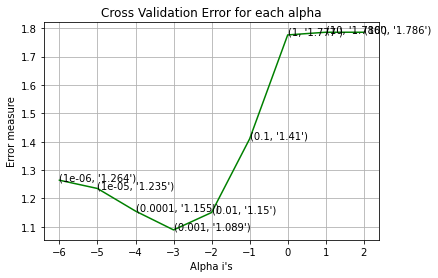

For values of best alpha =  0.001 The train log loss is: 0.5568921683835519
For values of best alpha =  0.001 The cross validation log loss is: 1.0890797562674541
For values of best alpha =  0.001 The test log loss is: 1.169854521681902


In [0]:
alpha,best_alpha = LinearSVM_Algo(X_Train,Y_Train,X_CV,Y_CV,X_Test,Y_Test)

## RANDOM FOREST CLASSIFIER

In [0]:
def Random_Forest_Algo(X_Train,Y_Train,X_CV,Y_CV,X_Test,Y_Test):
  alpha = [100,200,500,1000,2000]
  max_depth = [5, 10]
  cv_log_error = []
  for i in alpha:
      for j in max_depth:
          print("for n_estimators =", i,"and max depth = ", j)
          clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
          clf.fit(X_Train_onehotCoding, Y_Train)
          sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
          sig_clf.fit(X_Train_onehotCoding, Y_Train)
          sig_clf_probs = sig_clf.predict_proba(X_CV_onehotcoding)
          cv_log_error.append(log_loss(Y_CV, sig_clf_probs, labels=clf.classes_, eps=1e-15))
          print("Log Loss :",log_loss(Y_CV, sig_clf_probs))   
  best_alpha = np.argmin(cv_log_error)
  clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
  clf.fit(X_Train_onehotCoding, Y_Train)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(X_Train_onehotCoding, Y_Train)

  predict_y = sig_clf.predict_proba(X_Train_onehotCoding)
  print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(Y_Train, predict_y, labels=clf.classes_, eps=1e-15))
  predict_y = sig_clf.predict_proba(X_CV_onehotcoding)
  print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))
  predict_y = sig_clf.predict_proba(X_Test_onehotcoding)
  print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))
  return alpha ,best_alpha,max_depth

In [0]:
alpha,best_alpha,max_depth = Random_Forest_Algo(X_Train,Y_Train,X_CV,Y_CV,X_Test,Y_Test)

for n_estimators = 100 and max depth =  5
Log Loss : 1.2326184926589763
for n_estimators = 100 and max depth =  10
Log Loss : 1.1397704442148777
for n_estimators = 200 and max depth =  5
Log Loss : 1.2232699707646029
for n_estimators = 200 and max depth =  10
Log Loss : 1.134728006300164
for n_estimators = 500 and max depth =  5
Log Loss : 1.209239434844949
for n_estimators = 500 and max depth =  10
Log Loss : 1.128958113452009
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2088491589776875
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1265704644070151
for n_estimators = 2000 and max depth =  5
Log Loss : 1.212862831306057
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1264918458844675
For values of best estimator =  2000 The train log loss is: 0.6876705154867352
For values of best estimator =  2000 The cross validation log loss is: 1.1264918458844675
For values of best estimator =  2000 The test log loss is: 1.1666937468936616


Log Loss :  1.1264918458844675
Number of Misclassified Points : 0.3815789473684211
-------------------- Confusion Matrix --------------------


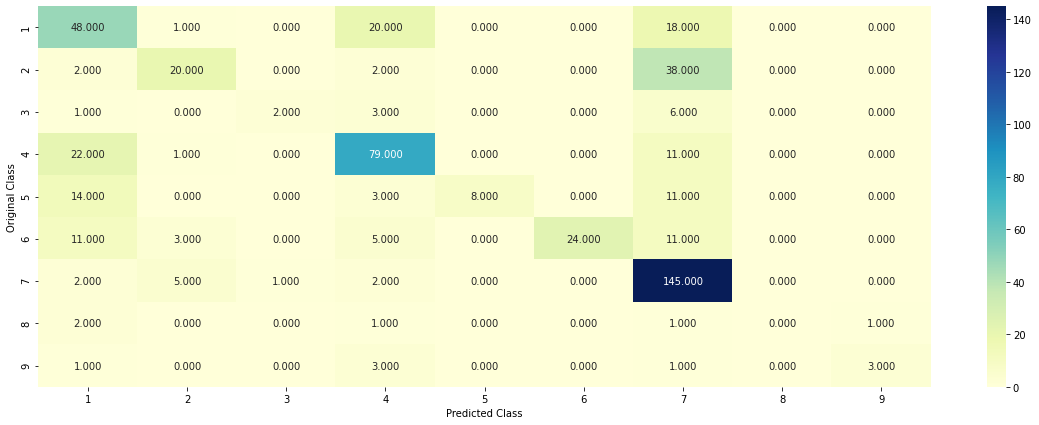

-------------------- Precision matrix (Columm Sum=1) --------------------


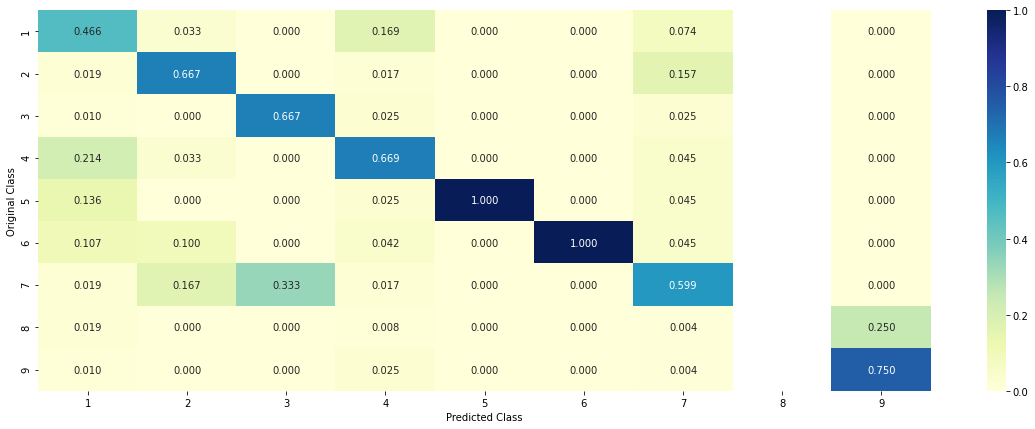

-------------------- Recall matrix (Row sum=1) --------------------


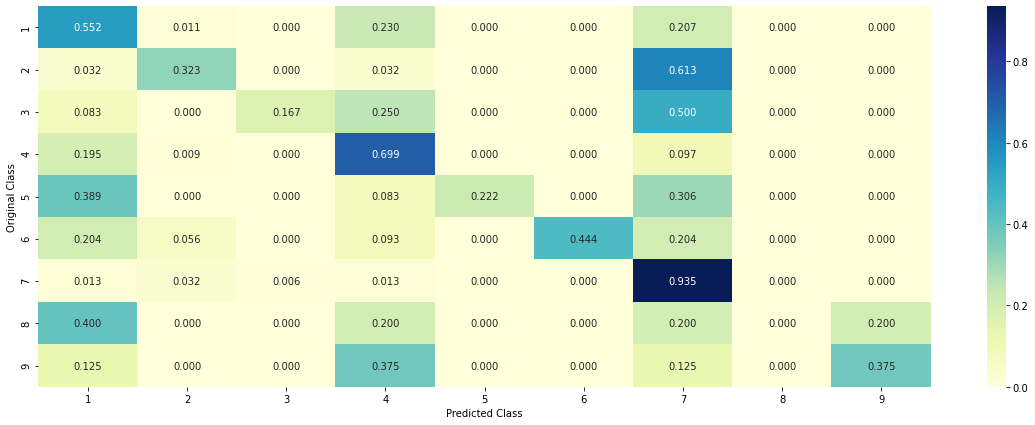

In [0]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusionmatrix(X_Train_onehotCoding, Y_Train, X_CV_onehotcoding, Y_CV, clf)

# TF-IDF FEATURIZATION TECHNIQUE 

## TF-IDF on Gene Features 

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
gene_vectorizer=TfidfVectorizer()

X_Train_gene_Feature_onehotencoding_tfidf=gene_vectorizer.fit_transform(X_Train["Gene"])
print(" Train Gene Feature :" ,X_Train_gene_Feature_onehotencoding_tfidf.shape)

print("="*100)

X_Test_gene_Feature_onehotencoding_tfidf=gene_vectorizer.transform(X_Test["Gene"])
print(" Test Gene Feature :" ,X_Test_gene_Feature_onehotencoding_tfidf.shape)

print("="*100)


X_CV_gene_Feature_onehotencoding_tfidf=gene_vectorizer.transform(X_CV["Gene"])
print(" CV Gene Feature :" ,X_CV_gene_Feature_onehotencoding_tfidf.shape)

print("="*100)

 Train Gene Feature : (2124, 225)
 Test Gene Feature : (665, 225)
 CV Gene Feature : (532, 225)


## TF-IDF on Variation Features

In [24]:
variation_vectorizer=TfidfVectorizer()

X_Train_variation_Feature_onehotencoding_tfidf=variation_vectorizer.fit_transform(X_Train["Variation"])
print(" Train Variation Feature :" ,X_Train_variation_Feature_onehotencoding_tfidf.shape)

print("="*100)

X_Test_variation_Feature_onehotencoding_tfidf=variation_vectorizer.transform(X_Test["Variation"])
print(" Test Variation Feature :" ,X_Test_variation_Feature_onehotencoding_tfidf.shape)

print("="*100)


X_CV_variation_Feature_onehotencoding_tfidf=variation_vectorizer.transform(X_CV["Variation"])
print(" CV Variation Feature :" ,X_CV_variation_Feature_onehotencoding_tfidf.shape)

print("="*100)

 Train Variation Feature : (2124, 1973)
 Test Variation Feature : (665, 1973)
 CV Variation Feature : (532, 1973)


## TF-IDF on Text Features 

In [0]:
text_vectorizer = TfidfVectorizer(min_df=5,ngram_range=(1,4),max_features=3000)
X_Train_feature_onehotencoding_tfidf = text_vectorizer.fit_transform(X_Train['TEXT'])
# getting all the feature names (words)

In [52]:
from sklearn.preprocessing import normalize

X_Train_feature_onehotencoding_tfidf = normalize(X_Train_feature_onehotencoding_tfidf, axis=0)
print("Train Text Feature :", X_Train_feature_onehotencoding_tfidf.shape)

print("="*100)

X_Test_text_feature_onehotencoding_tfidf = text_vectorizer.transform(X_Test['TEXT'])
print("Test Text Feature :", X_Test_text_feature_onehotencoding_tfidf.shape)

print("="*100)

X_Test_text_feature_onehotencoding_tfidf = normalize(X_Test_text_feature_onehotencoding_tfidf, axis=0)

X_CV_text_feature_onehotencoding_tfidf = text_vectorizer.transform(X_CV['TEXT'])
print("CV Text Feature :", X_CV_text_feature_onehotencoding_tfidf.shape)

print("="*100)

X_CV_text_feature_onehotencoding_tfidf = normalize(X_CV_text_feature_onehotencoding_tfidf, axis=0)

Train Text Feature : (2124, 3000)
Test Text Feature : (665, 3000)
CV Text Feature : (532, 3000)


## STACKING THE THREE TYPES OF FEATURES 

In [53]:
X_Train_gene_var_onehotencoding_tfidf = hstack((X_Train_gene_Feature_onehotencoding_tfidf,X_Train_variation_Feature_onehotencoding_tfidf))
X_Test_gene_var_onehotencoding_tfidf =  hstack((X_Test_gene_Feature_onehotencoding_tfidf,X_Test_variation_Feature_onehotencoding_tfidf))
X_CV_gene_var_onehotencoding_tfidf = hstack((X_CV_gene_Feature_onehotencoding_tfidf,X_CV_variation_Feature_onehotencoding_tfidf))
  
X_Train_onehotcoding_tfidf = hstack((X_Train_gene_var_onehotencoding_tfidf,X_Train_feature_onehotencoding_tfidf)).tocsr()
print("Train One Hot Encoding  :", X_Train_onehotcoding_tfidf.shape)
print("="*100)

X_Test_onehotcoding_tfidf = hstack((X_Test_gene_var_onehotencoding_tfidf,X_Test_text_feature_onehotencoding_tfidf)).tocsr()
print("Test One Hot Encoding  :", X_Test_onehotcoding_tfidf.shape)
print("="*100)

X_CV_onehotcoding_tfidf = hstack((X_CV_gene_var_onehotencoding_tfidf,X_CV_text_feature_onehotencoding_tfidf)).tocsr()
print("CV One Hot Encoding  :", X_CV_onehotcoding_tfidf.shape)
print("="*100)

Train One Hot Encoding  : (2124, 5198)
Test One Hot Encoding  : (665, 5198)
CV One Hot Encoding  : (532, 5198)


## NAIVE BAYES ALGORITHM

for alpha = 1e-05
Log Loss : 1.2852242745511553
for alpha = 0.0001
Log Loss : 1.2899281532020483
for alpha = 0.001
Log Loss : 1.2958675085806037
for alpha = 0.1
Log Loss : 1.293202683703183
for alpha = 1
Log Loss : 1.2686115338014161
for alpha = 10
Log Loss : 1.3132818674896714
for alpha = 100
Log Loss : 1.2940842269235393
for alpha = 1000
Log Loss : 1.2440531436451192


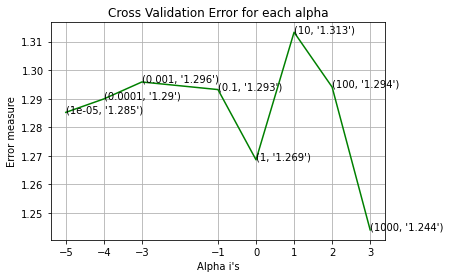

For values of best alpha =  1000 The train log loss is: 0.8125492088099504
For values of best alpha =  1000 The cross validation log loss is: 1.2440531436451192
For values of best alpha =  1000 The test log loss is: 1.2117067312528402


In [0]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(X_Train_onehotcoding_tfidf, Y_Train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_Train_onehotcoding_tfidf, Y_Train)
    sig_clf_probs = sig_clf.predict_proba(X_CV_onehotcoding_tfidf)
    cv_log_error_array.append(log_loss(Y_CV, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_CV, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(X_Train_onehotcoding_tfidf, Y_Train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_Train_onehotcoding_tfidf, Y_Train)


predict_y = sig_clf.predict_proba(X_Train_onehotcoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_Train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_CV_onehotcoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_Test_onehotcoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))

Log Loss : 1.2000466448985152
Number of missclassified point : 0.42857142857142855
-------------------- Confusion Matrix --------------------


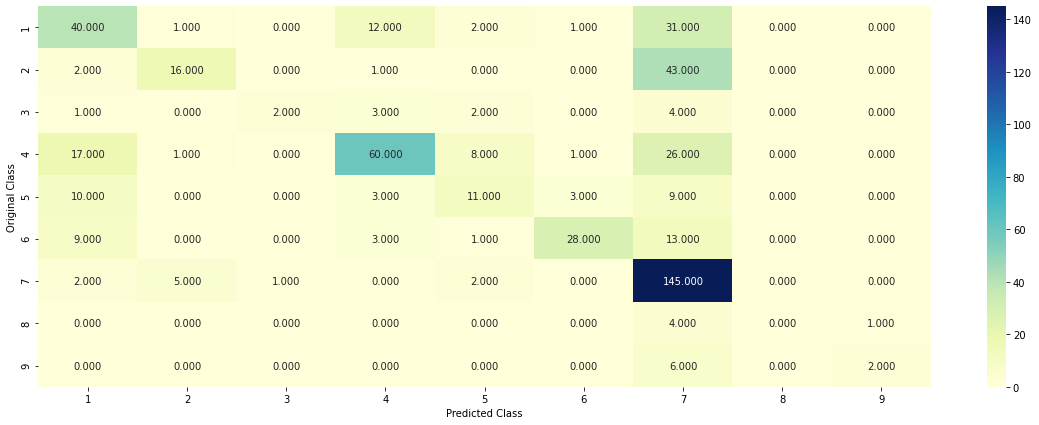

-------------------- Precision matrix (Columm Sum=1) --------------------


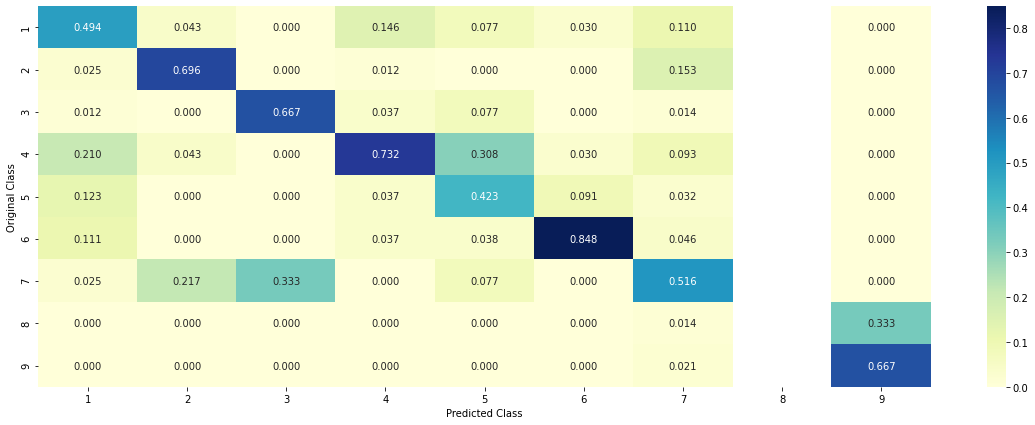

-------------------- Recall matrix (Row sum=1) --------------------


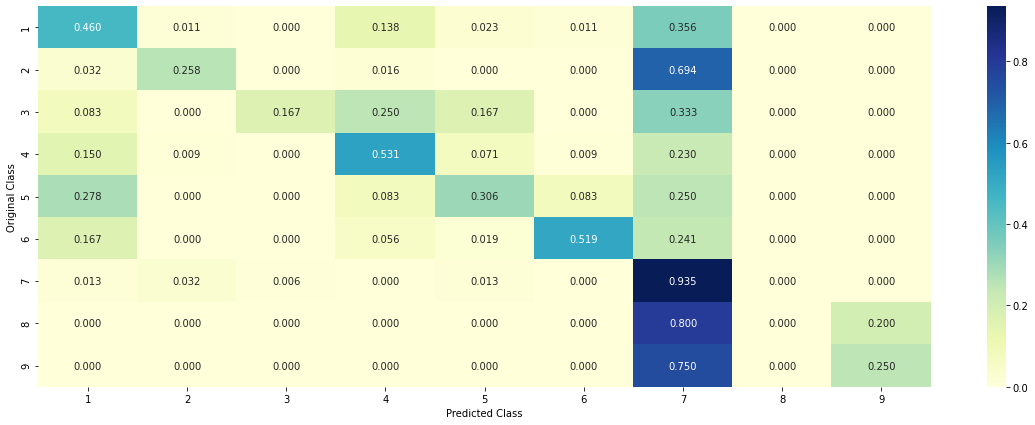

In [0]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(X_Train_onehotcoding_tfidf, Y_Train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_Train_onehotcoding_tfidf, Y_Train)
sig_clf_probs = sig_clf.predict_proba(X_CV_onehotcoding_tfidf)

print("Log Loss :",log_loss(Y_CV, sig_clf_probs))

print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(X_CV_onehotcoding_tfidf)- Y_CV))/Y_CV.shape[0])
plot_confusion_matrix(Y_CV, sig_clf.predict(X_CV_onehotcoding_tfidf.toarray()))

## K-NEAREST NEIGHBORS ALGORITHM

for alpha = 5
Log Loss : 1.260740792425099
for alpha = 11
Log Loss : 1.3267641338744462
for alpha = 15
Log Loss : 1.3556204961769065
for alpha = 21
Log Loss : 1.386854135603434
for alpha = 31
Log Loss : 1.4147264394638535
for alpha = 41
Log Loss : 1.4384943533717045
for alpha = 51
Log Loss : 1.4309811480079746
for alpha = 99
Log Loss : 1.4545118320471948


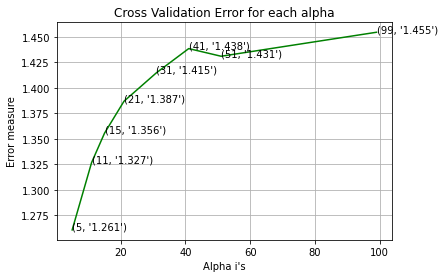

For values of best alpha =  5 The train log loss is: 0.9761702316025991
For values of best alpha =  5 The cross validation log loss is: 1.260740792425099
For values of best alpha =  5 The test log loss is: 1.283216135778764


In [0]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_Train_onehotcoding_tfidf, Y_Train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_Train_onehotcoding_tfidf, Y_Train)
    sig_clf_probs = sig_clf.predict_proba(X_CV_onehotcoding_tfidf)
    cv_log_error_array.append(log_loss(Y_CV, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_CV, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(X_Train_onehotcoding_tfidf, Y_Train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_Train_onehotcoding_tfidf, Y_Train)

predict_y = sig_clf.predict_proba(X_Train_onehotcoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_Train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_CV_onehotcoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_Test_onehotcoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))

Log Loss :  1.260740792425099
Number of Misclassified Points : 0.4323308270676692
-------------------- Confusion Matrix --------------------


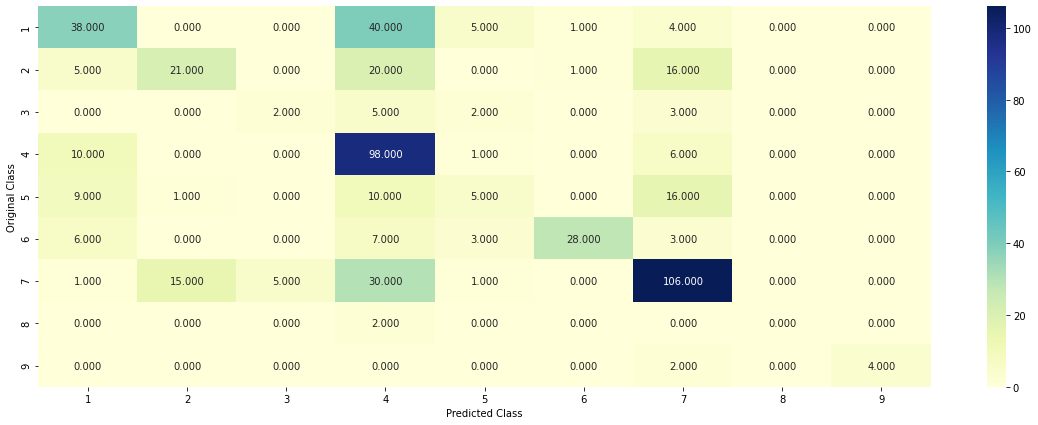

-------------------- Precision matrix (Columm Sum=1) --------------------


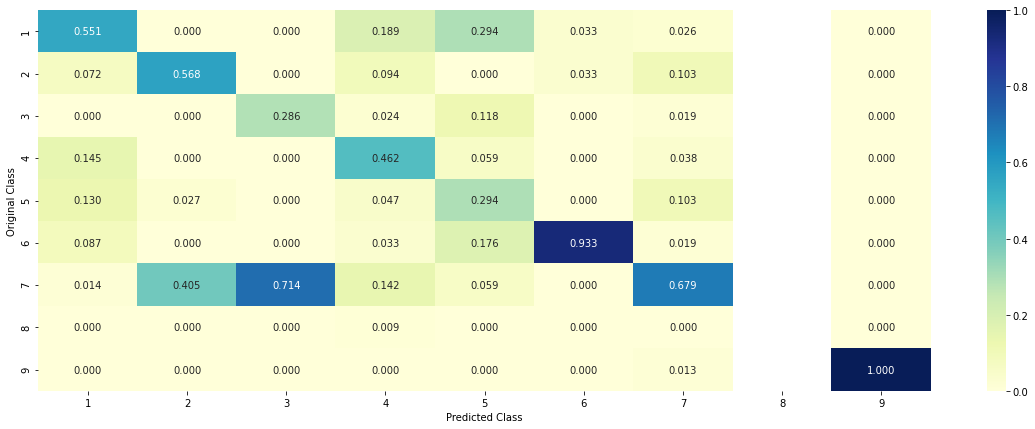

-------------------- Recall matrix (Row sum=1) --------------------


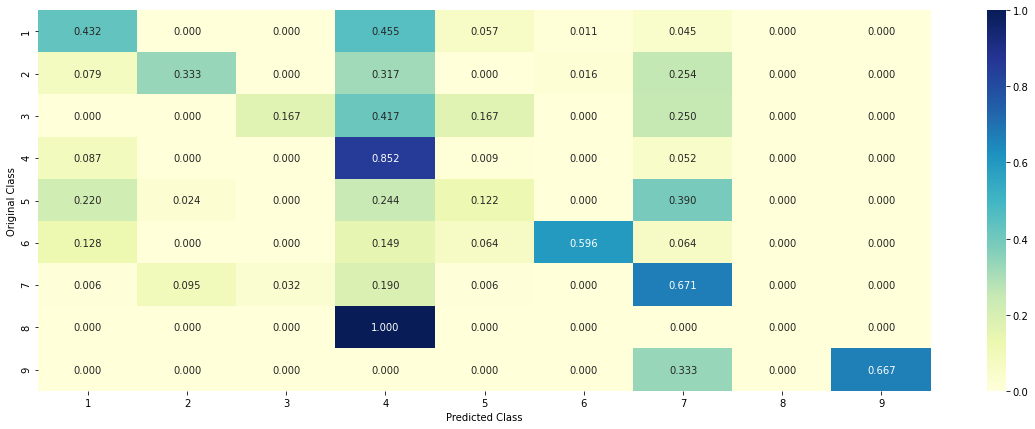

In [0]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusionmatrix(X_Train_onehotcoding_tfidf, Y_Train, X_CV_onehotcoding_tfidf, Y_CV, clf)

In [0]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(X_Train_onehotcoding_tfidf, Y_Train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_Train_onehotcoding_tfidf, Y_Train)

test_point_index = 1
predicted_cls = sig_clf.predict(X_Test_onehotcoding_tfidf[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_Test[test_point_index])
neighbors = clf.kneighbors(X_Test_onehotcoding_tfidf[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",Y_Train[neighbors[1][0]])
print("Fequency of nearest points :",Counter(Y_Train[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 4
The  5  nearest neighbours of the test points belongs to classes [3 4 1 4 1]
Fequency of nearest points : Counter({4: 2, 1: 2, 3: 1})


## LOGISTIC REGRESSION WITH CLASS BALANCING 

for alpha = 1e-06
Log Loss : 1.1349239214992324
for alpha = 1e-05
Log Loss : 1.1270021942239883
for alpha = 0.0001
Log Loss : 1.0584224477093065
for alpha = 0.001
Log Loss : 1.0848800628677302
for alpha = 0.01
Log Loss : 1.2267667992253835
for alpha = 0.1
Log Loss : 1.7127788552336967
for alpha = 1
Log Loss : 1.8391919496093834
for alpha = 10
Log Loss : 1.85154108049996
for alpha = 100
Log Loss : 1.8529278523272878


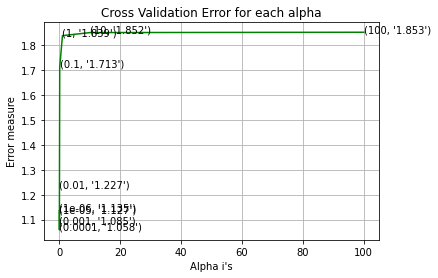

For values of best alpha =  0.0001 The train log loss is: 0.36081440897296463
For values of best alpha =  0.0001 The cross validation log loss is: 1.0584224477093065
For values of best alpha =  0.0001 The test log loss is: 1.0564367265738994


In [54]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_Train_onehotcoding_tfidf, Y_Train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_Train_onehotcoding_tfidf, Y_Train)
    sig_clf_probs = sig_clf.predict_proba(X_CV_onehotcoding_tfidf)
    cv_log_error_array.append(log_loss(Y_CV, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_CV, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_Train_onehotcoding_tfidf, Y_Train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_Train_onehotcoding_tfidf, Y_Train)

predict_y = sig_clf.predict_proba(X_Train_onehotcoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_Train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_CV_onehotcoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_Test_onehotcoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))

Log Loss :  1.0584224477093065
Number of Misclassified Points : 0.34398496240601506
-------------------- Confusion Matrix --------------------


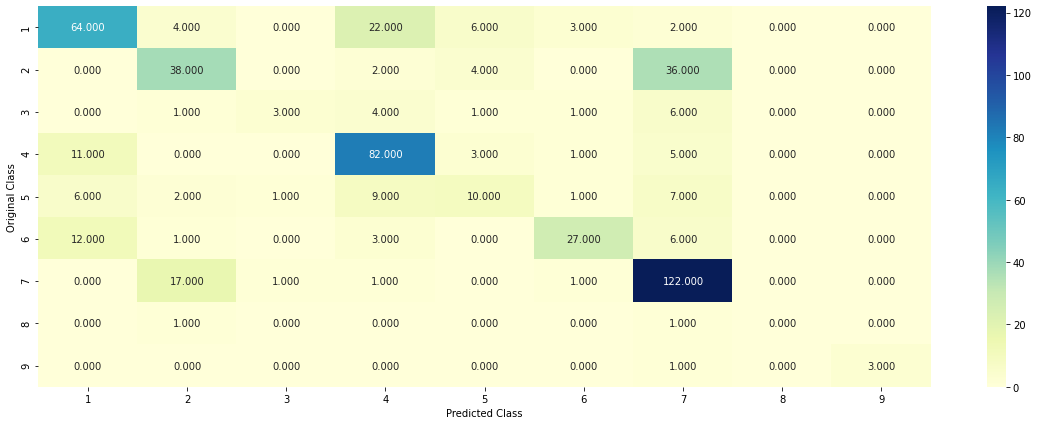

-------------------- Precision matrix (Columm Sum=1) --------------------


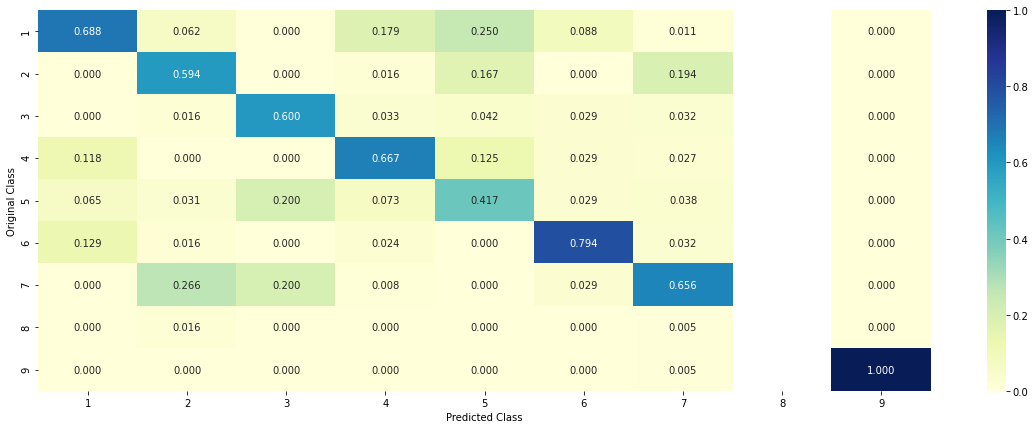

-------------------- Recall matrix (Row sum=1) --------------------


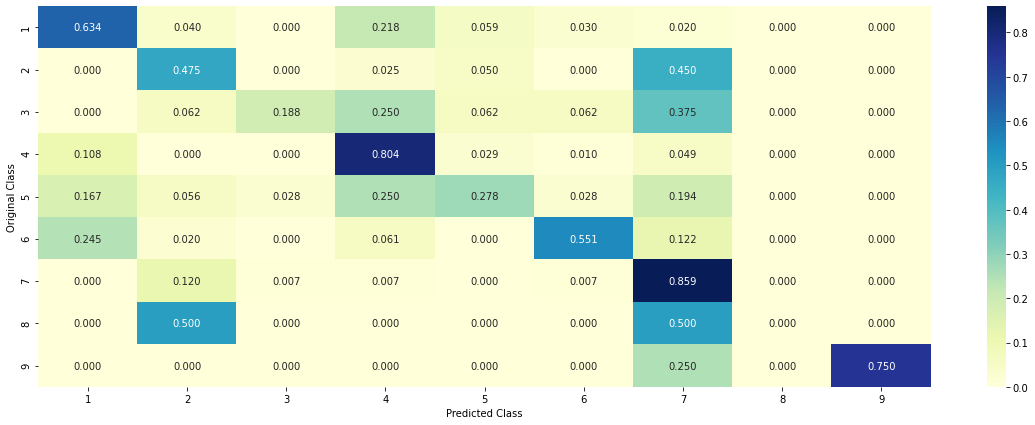

In [55]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusionmatrix(X_Train_onehotcoding_tfidf, Y_Train, X_CV_onehotcoding_tfidf, Y_CV, clf)

## LOGISTIC REGRESSION WITHOUT CLASS BALANCING 

for alpha = 1e-06
Log Loss : 1.1386593648101406
for alpha = 1e-05
Log Loss : 1.1280770426263258
for alpha = 0.0001
Log Loss : 1.0809267874605049
for alpha = 0.001
Log Loss : 1.1599651555818726
for alpha = 0.01
Log Loss : 1.4711079574295722
for alpha = 0.1
Log Loss : 1.7324620156684516
for alpha = 1
Log Loss : 1.862433088524242
for alpha = 10
Log Loss : 1.8771853566934507
for alpha = 100
Log Loss : 1.8788362002968801


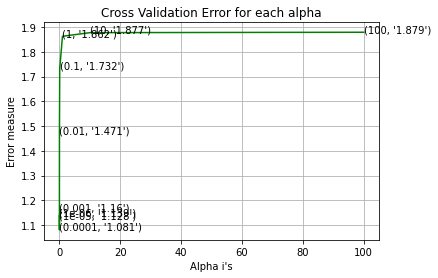

For values of best alpha =  0.0001 The train log loss is: 0.3551967798023194
For values of best alpha =  0.0001 The cross validation log loss is: 1.0809267874605049
For values of best alpha =  0.0001 The test log loss is: 1.0689818390115837


In [56]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_Train_onehotcoding_tfidf, Y_Train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_Train_onehotcoding_tfidf, Y_Train)
    sig_clf_probs = sig_clf.predict_proba(X_CV_onehotcoding_tfidf)
    cv_log_error_array.append(log_loss(Y_CV, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_CV, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_Train_onehotcoding_tfidf, Y_Train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_Train_onehotcoding_tfidf, Y_Train)

predict_y = sig_clf.predict_proba(X_Train_onehotcoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_Train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_CV_onehotcoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_Test_onehotcoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))

Log Loss :  1.0809267874605049
Number of Misclassified Points : 0.3533834586466165
-------------------- Confusion Matrix --------------------


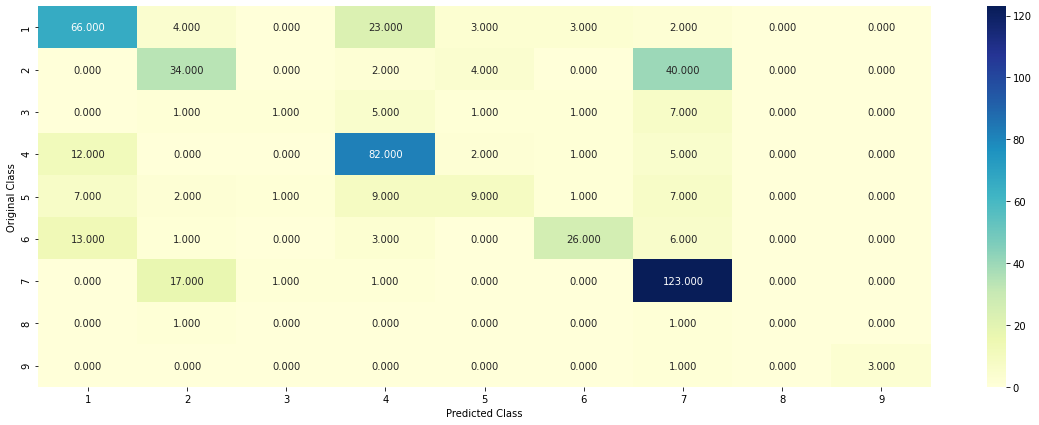

-------------------- Precision matrix (Columm Sum=1) --------------------


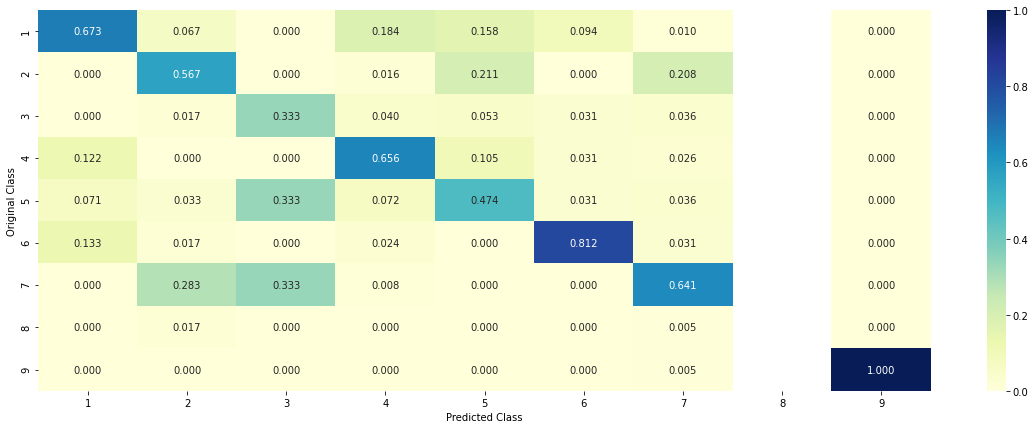

-------------------- Recall matrix (Row sum=1) --------------------


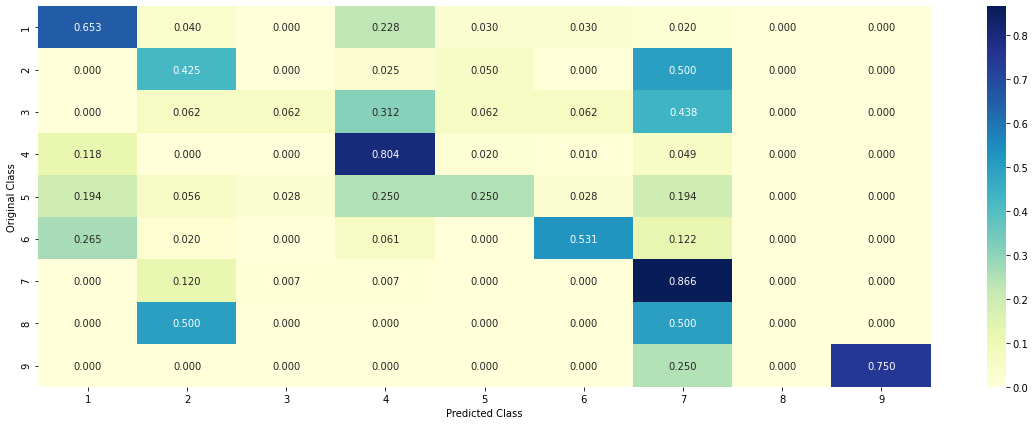

In [57]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusionmatrix(X_Train_onehotcoding_tfidf, Y_Train, X_CV_onehotcoding_tfidf, Y_CV, clf)

## LINEAR SUPPORT VECTOR MACHINE 

for alpha = 1e-06
Log Loss : 1.734070273152867
for alpha = 1e-05
Log Loss : 1.5862485898229866
for alpha = 0.0001
Log Loss : 1.5936267988881776
for alpha = 0.001
Log Loss : 1.5479693059157946
for alpha = 0.01
Log Loss : 1.259227904947885
for alpha = 0.1
Log Loss : 1.209470514614952
for alpha = 1
Log Loss : 1.2419308317562618
for alpha = 10
Log Loss : 1.2300727496186747
for alpha = 100
Log Loss : 1.2377818397838432


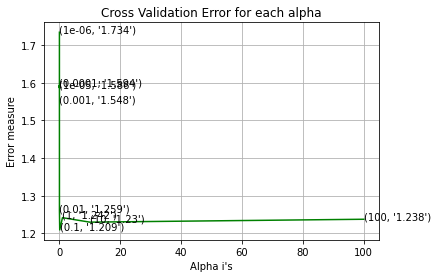

For values of best alpha =  0.1 The train log loss is: 0.6762797047280953
For values of best alpha =  0.1 The cross validation log loss is: 1.209470514614952
For values of best alpha =  0.1 The test log loss is: 1.22387181005077


In [0]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced',alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_Train_onehotcoding_tfidf, Y_Train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_Train_onehotcoding_tfidf, Y_Train)
    sig_clf_probs = sig_clf.predict_proba(X_CV_onehotcoding_tfidf)
    cv_log_error_array.append(log_loss(Y_CV, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_CV, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced',alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_Train_onehotcoding_tfidf, Y_Train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_Train_onehotcoding_tfidf, Y_Train)

predict_y = sig_clf.predict_proba(X_Train_onehotcoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_Train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_CV_onehotcoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_Test_onehotcoding_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))

Log Loss :  1.209470514614952
Number of Misclassified Points : 0.40037593984962405
-------------------- Confusion Matrix --------------------


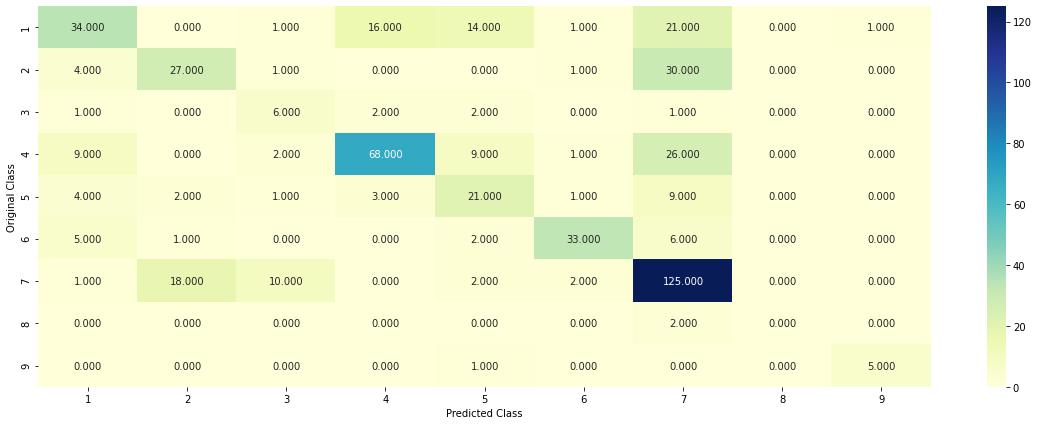

-------------------- Precision matrix (Columm Sum=1) --------------------


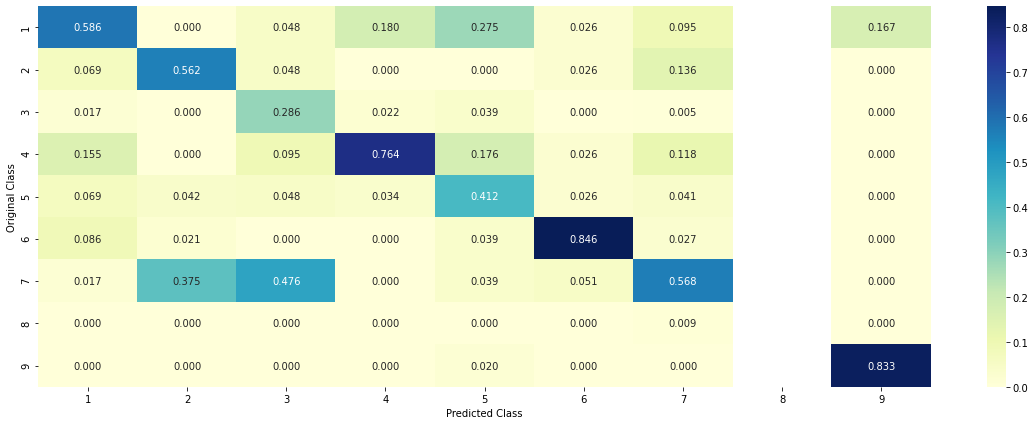

-------------------- Recall matrix (Row sum=1) --------------------


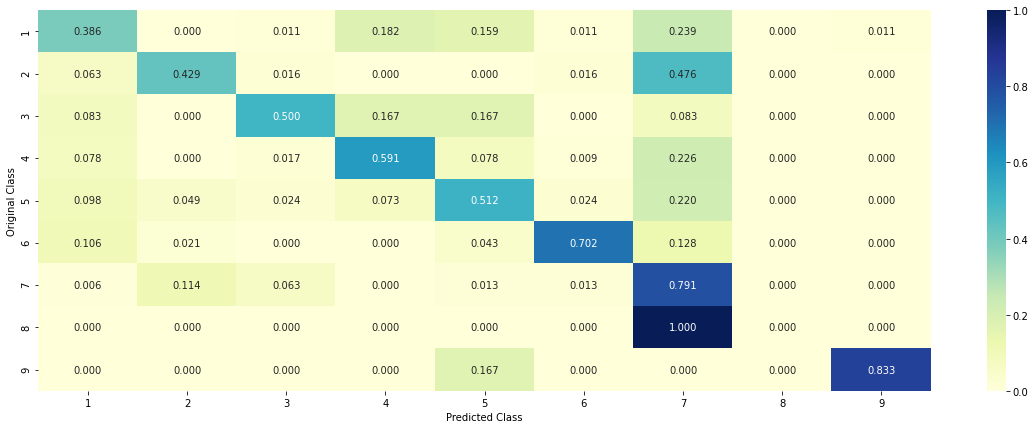

In [0]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusionmatrix(X_Train_onehotcoding_tfidf, Y_Train,X_CV_onehotcoding_tfidf,Y_CV, clf)

## RANDOM FOREST CLASSIFIER 

In [0]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(X_Train_onehotcoding_tfidf, Y_Train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_Train_onehotcoding_tfidf, Y_Train)
        sig_clf_probs = sig_clf.predict_proba(X_CV_onehotcoding_tfidf)
        cv_log_error_array.append(log_loss(Y_CV, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(Y_CV, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(X_Train_onehotcoding_tfidf, Y_Train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_Train_onehotcoding_tfidf, Y_Train)

predict_y = sig_clf.predict_proba(X_Train_onehotcoding_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(Y_Train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_CV_onehotcoding_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_Test_onehotcoding_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.3510317582905607
for n_estimators = 100 and max depth =  10
Log Loss : 1.247738810364953
for n_estimators = 200 and max depth =  5
Log Loss : 1.3455752145339397
for n_estimators = 200 and max depth =  10
Log Loss : 1.246776791529552
for n_estimators = 500 and max depth =  5
Log Loss : 1.334177453757526
for n_estimators = 500 and max depth =  10
Log Loss : 1.2418326127033907
for n_estimators = 1000 and max depth =  5
Log Loss : 1.332294027322561
for n_estimators = 1000 and max depth =  10


## STACK THE MODELS 

In [0]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(X_Train_onehotcoding_tfidf, Y_Train)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

In [0]:
clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(X_Train_onehotcoding_tfidf, Y_Train)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

In [0]:
clf3 = MultinomialNB(alpha=0.001)
clf3.fit(X_Train_onehotcoding_tfidf, Y_Train)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

In [0]:
sig_clf1.fit(X_Train_onehotcoding_tfidf, Y_Train)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(Y_CV, sig_clf1.predict_proba(X_CV_onehotcoding_tfidf))))
sig_clf2.fit(X_Train_onehotcoding_tfidf, Y_Train)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(Y_CV, sig_clf2.predict_proba(X_CV_onehotcoding_tfidf))))

Logistic Regression :  Log Loss: 1.32
Support vector machines : Log Loss: 1.29


In [0]:
sig_clf3.fit(X_Train_onehotcoding_tfidf, Y_Train)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(Y_CV, sig_clf3.predict_proba(X_CV_onehotcoding_tfidf))))
print("-"*50)

Naive Bayes : Log Loss: 1.29
--------------------------------------------------


In [0]:
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(X_Train_onehotcoding_tfidf, Y_Train)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(Y_CV, sclf.predict_proba(X_CV_onehotcoding_tfidf))))
    log_error =log_loss(Y_CV , sclf.predict_proba(X_CV_onehotcoding_tfidf))
    if best_alpha > log_error:
        best_alpha = log_error

Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.825
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.738
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.364
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.193
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.367
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.648


Log loss (train) on the stacking classifier : 0.5856455884200168
Log loss (CV) on the stacking classifier : 1.1928162759065564
Log loss (test) on the stacking classifier : 1.2314016594501591
Number of missclassified point : 0.39849624060150374
-------------------- Confusion Matrix --------------------


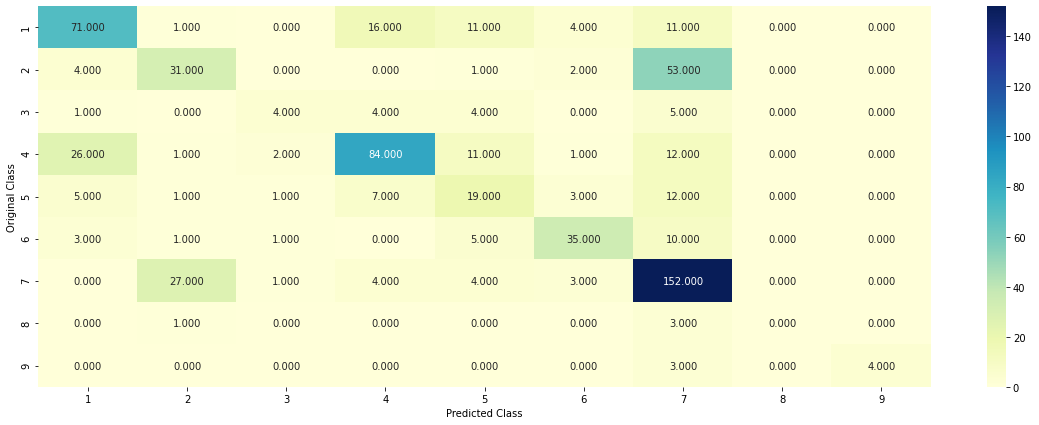

-------------------- Precision matrix (Columm Sum=1) --------------------


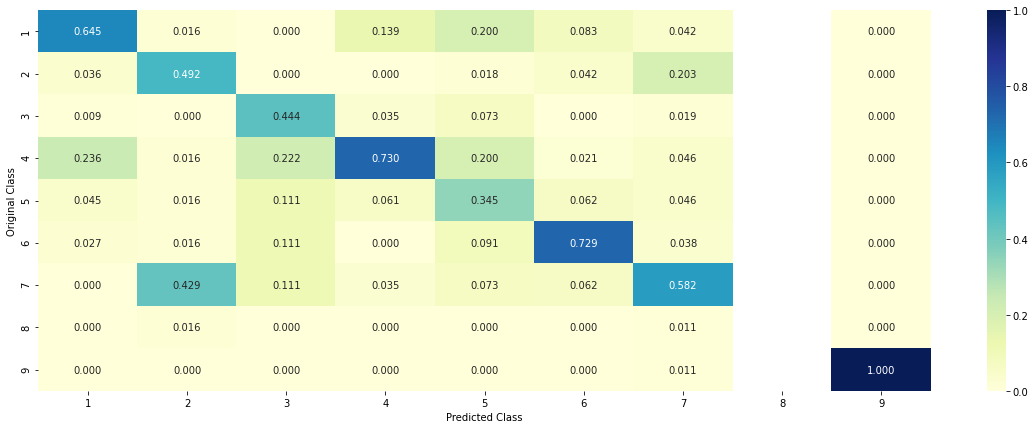

-------------------- Recall matrix (Row sum=1) --------------------


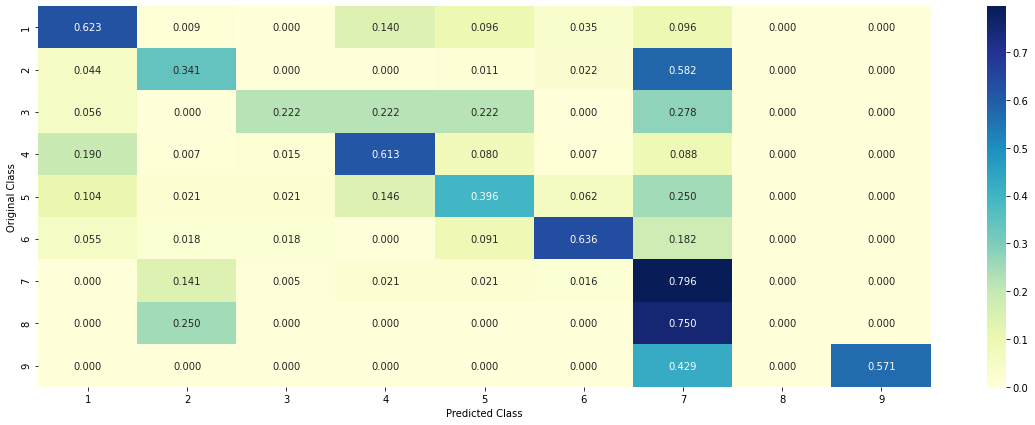

In [0]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(X_Train_onehotcoding_tfidf, Y_Train)

log_error = log_loss(Y_Train, sclf.predict_proba(X_Train_onehotcoding_tfidf))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(Y_CV, sclf.predict_proba(X_CV_onehotcoding_tfidf))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(Y_Test, sclf.predict_proba(X_Test_onehotcoding_tfidf))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(X_Test_onehotcoding_tfidf)- Y_Test))/Y_Test.shape[0])
plot_confusion_matrix(test_y=Y_Test, predict_y=sclf.predict(X_Test_onehotcoding_tfidf))

# LOGISTIC REGRESSION WITH COUNTVECTORIZER USING BIGRAM 

## CountVectorizer on Gene Features

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer_bigram=CountVectorizer(ngram_range=(1,2))

X_Train_gene_Feature_onehotencoding_bigram=count_vectorizer_bigram.fit_transform(X_Train["Gene"])
print(" Train Gene Feature :" ,X_Train_gene_Feature_onehotencoding_bigram.shape)

print("="*100)

X_Test_gene_Feature_onehotencoding_bigram=count_vectorizer_bigram.transform(X_Test["Gene"])
print(" Test Gene Feature :" ,X_Test_gene_Feature_onehotencoding_bigram.shape)

print("="*100)


X_CV_gene_Feature_onehotencoding_bigram=count_vectorizer_bigram.transform(X_CV["Gene"])
print(" CV Gene Feature :" ,X_CV_gene_Feature_onehotencoding_bigram.shape)

print("="*100)

 Train Gene Feature : (2124, 238)
 Test Gene Feature : (665, 238)
 CV Gene Feature : (532, 238)


## CountVectorizer on Variation Features

In [0]:
variation_vectorizer_bigram=CountVectorizer(ngram_range=(1,2))

X_Train_variation_Feature_onehotencoding_bigram=variation_vectorizer_bigram.fit_transform(X_Train["Variation"])
print(" Train Variation Feature :" ,X_Train_variation_Feature_onehotencoding_bigram.shape)

print("="*100)

X_Test_variation_Feature_onehotencoding_bigram=variation_vectorizer_bigram.transform(X_Test["Variation"])
print(" Test Variation Feature :" ,X_Test_variation_Feature_onehotencoding_bigram.shape)

print("="*100)


X_CV_variation_Feature_onehotencoding_bigram=variation_vectorizer_bigram.transform(X_CV["Variation"])
print(" CV Variation Feature :" ,X_CV_variation_Feature_onehotencoding_bigram.shape)

print("="*100)

 Train Variation Feature : (2124, 2059)
 Test Variation Feature : (665, 2059)
 CV Variation Feature : (532, 2059)


## CountVectorizer on Text Features

In [0]:
from sklearn.preprocessing import normalize

text_vectorizer_bigram = CountVectorizer(min_df=3,ngram_range=(1,2))
X_Train_feature_onehotencoding_bigram = text_vectorizer_bigram.fit_transform(X_Train['TEXT'])


X_Train_feature_onehotencoding_bigram = normalize(X_Train_feature_onehotencoding_bigram, axis=0)
print("Train Text Feature :", X_Train_feature_onehotencoding_bigram.shape)

print("="*100)

X_Test_text_feature_onehotencoding_bigram = text_vectorizer_bigram.transform(X_Test['TEXT'])
print("Test Text Feature :", X_Test_text_feature_onehotencoding_bigram.shape)

print("="*100)

X_Test_text_feature_onehotencoding_bigram = normalize(X_Test_text_feature_onehotencoding_bigram, axis=0)

X_CV_text_feature_onehotencoding_bigram = text_vectorizer_bigram.transform(X_CV['TEXT'])
print("CV Text Feature :", X_CV_text_feature_onehotencoding_bigram.shape)

print("="*100)

X_CV_text_feature_onehotencoding_bigram = normalize(X_CV_text_feature_onehotencoding_bigram, axis=0)

Train Text Feature : (2124, 778049)
Test Text Feature : (665, 778049)
CV Text Feature : (532, 778049)


## STACKING THE 3 TYPES OF FEATURES

In [0]:
X_Train_gene_var_onehotencoding_bigram = hstack((X_Train_gene_Feature_onehotencoding_bigram,X_Train_variation_Feature_onehotencoding_bigram))
X_Test_gene_var_onehotencoding_bigram =  hstack((X_Test_gene_Feature_onehotencoding_bigram,X_Test_variation_Feature_onehotencoding_bigram))
X_CV_gene_var_onehotencoding_bigram = hstack((X_CV_gene_Feature_onehotencoding_bigram,X_CV_variation_Feature_onehotencoding_bigram))
  
X_Train_onehotcoding_bigram = hstack((X_Train_gene_var_onehotencoding_bigram,X_Train_feature_onehotencoding_bigram)).tocsr()
print("Train One Hot Encoding  :", X_Train_onehotcoding_bigram.shape)
print("="*100)

X_Test_onehotcoding_bigram = hstack((X_Test_gene_var_onehotencoding_bigram,X_Test_text_feature_onehotencoding_bigram)).tocsr()
print("Test One Hot Encoding  :", X_Test_onehotcoding_bigram.shape)
print("="*100)

X_CV_onehotcoding_bigram = hstack((X_CV_gene_var_onehotencoding_bigram,X_CV_text_feature_onehotencoding_bigram)).tocsr()
print("CV One Hot Encoding  :", X_CV_onehotcoding_bigram.shape)
print("="*100)

Train One Hot Encoding  : (2124, 780346)
Test One Hot Encoding  : (665, 780346)
CV One Hot Encoding  : (532, 780346)


## LOGISTIC REGRESSION WITH CLASS BALANCING

for alpha = 1e-06
Log Loss : 1.4970561274483982
for alpha = 1e-05
Log Loss : 1.5010399995551307
for alpha = 0.0001
Log Loss : 1.424062676611509
for alpha = 0.001
Log Loss : 1.1660539231940938
for alpha = 0.01
Log Loss : 1.1827551623816412
for alpha = 0.1
Log Loss : 1.2448482391400382
for alpha = 1
Log Loss : 1.3237901638703657
for alpha = 10
Log Loss : 1.394742504728744
for alpha = 100
Log Loss : 1.41038001550772


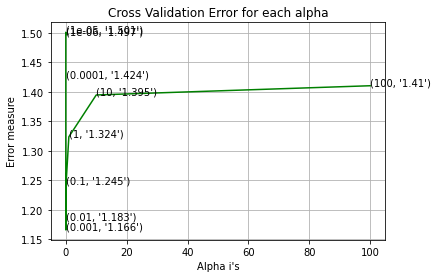

For values of best alpha =  0.001 The train log loss is: 0.6806336744933623
For values of best alpha =  0.001 The cross validation log loss is: 1.1660539231940938
For values of best alpha =  0.001 The test log loss is: 1.1964400260934125


In [0]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_Train_onehotcoding_bigram, Y_Train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_Train_onehotcoding_bigram, Y_Train)
    sig_clf_probs = sig_clf.predict_proba(X_CV_onehotcoding_bigram)
    cv_log_error_array.append(log_loss(Y_CV, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_CV, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_Train_onehotcoding_bigram, Y_Train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_Train_onehotcoding_bigram, Y_Train)

predict_y = sig_clf.predict_proba(X_Train_onehotcoding_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_Train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_CV_onehotcoding_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_Test_onehotcoding_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))

Log Loss :  1.1660539231940938
Number of Misclassified Points : 0.3533834586466165
-------------------- Confusion Matrix --------------------


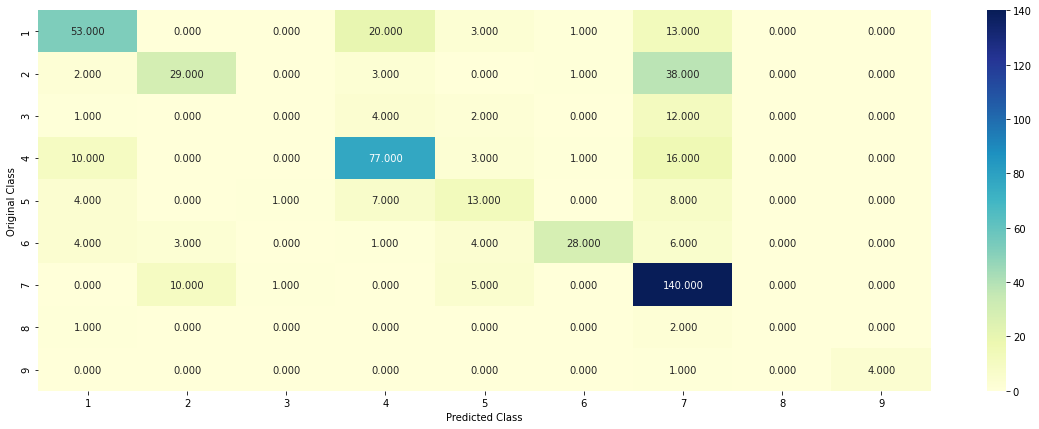

-------------------- Precision matrix (Columm Sum=1) --------------------


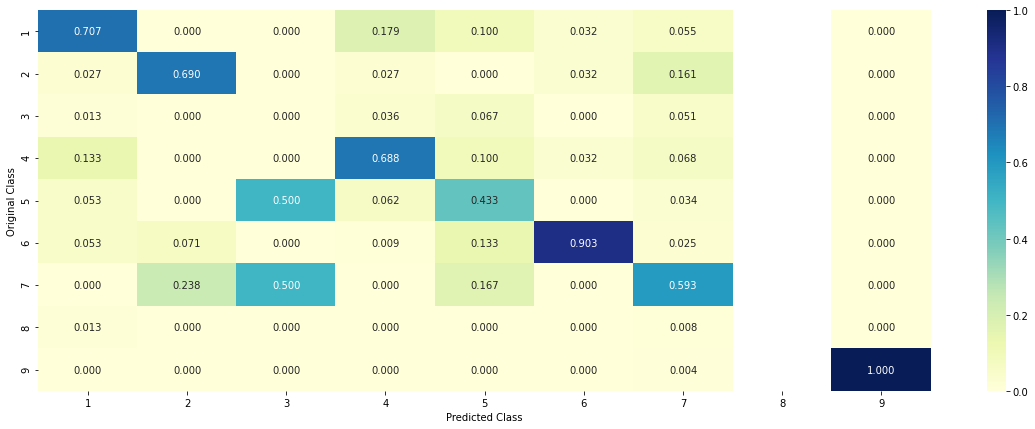

-------------------- Recall matrix (Row sum=1) --------------------


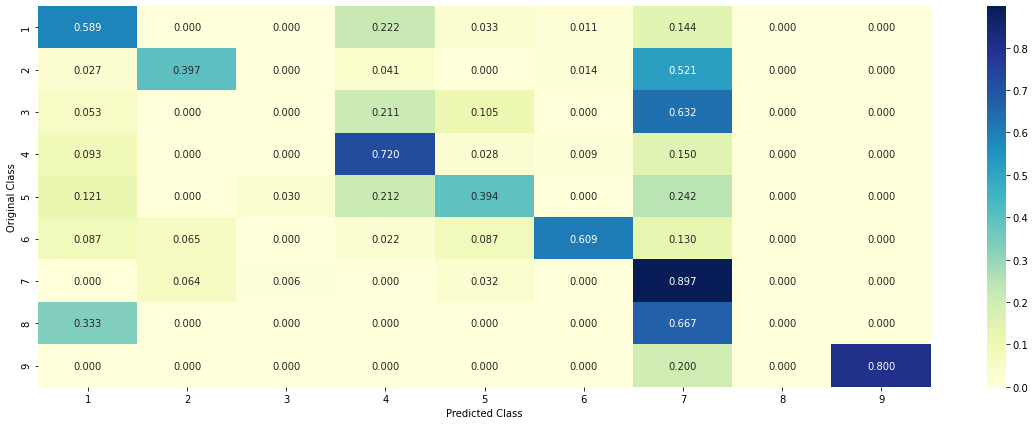

In [0]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusionmatrix(X_Train_onehotcoding_bigram, Y_Train, X_CV_onehotcoding_bigram, Y_CV, clf)

## LOGISTIC REGRESSION WITHOUT CLASS BALANCING

for alpha = 1e-06
Log Loss : 1.4549649168403047
for alpha = 1e-05
Log Loss : 1.4549225110267645
for alpha = 0.0001
Log Loss : 1.4030703907091053
for alpha = 0.001
Log Loss : 1.1935592472017653
for alpha = 0.01
Log Loss : 1.1912905725828355
for alpha = 0.1
Log Loss : 1.250560230497802
for alpha = 1
Log Loss : 1.3475273202679858
for alpha = 10
Log Loss : 1.417827791185307
for alpha = 100
Log Loss : 1.4309251269610022


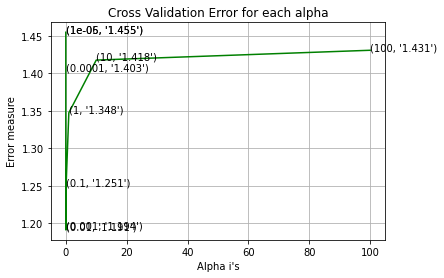

For values of best alpha =  0.01 The train log loss is: 0.635743757869479
For values of best alpha =  0.01 The cross validation log loss is: 1.1912905725828355
For values of best alpha =  0.01 The test log loss is: 1.1972669192372967


In [0]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_Train_onehotcoding_bigram, Y_Train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_Train_onehotcoding_bigram, Y_Train)
    sig_clf_probs = sig_clf.predict_proba(X_CV_onehotcoding_bigram)
    cv_log_error_array.append(log_loss(Y_CV, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_CV, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_Train_onehotcoding_bigram, Y_Train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_Train_onehotcoding_bigram, Y_Train)

predict_y = sig_clf.predict_proba(X_Train_onehotcoding_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_Train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_CV_onehotcoding_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_Test_onehotcoding_bigram)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))

Log Loss :  1.1912905725828355
Number of Misclassified Points : 0.3533834586466165
-------------------- Confusion Matrix --------------------


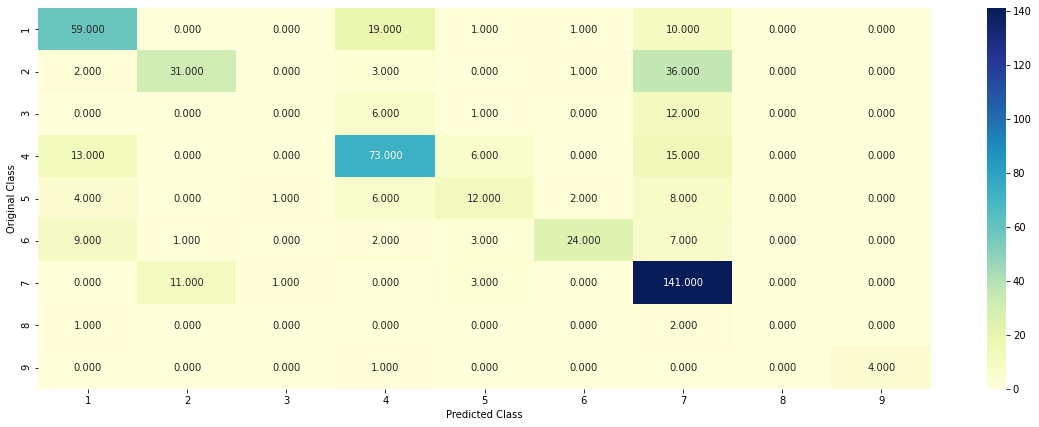

-------------------- Precision matrix (Columm Sum=1) --------------------


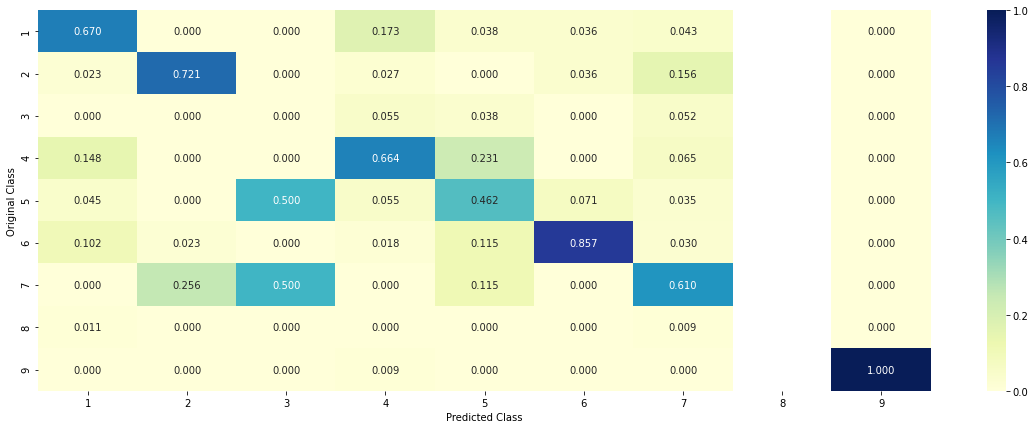

-------------------- Recall matrix (Row sum=1) --------------------


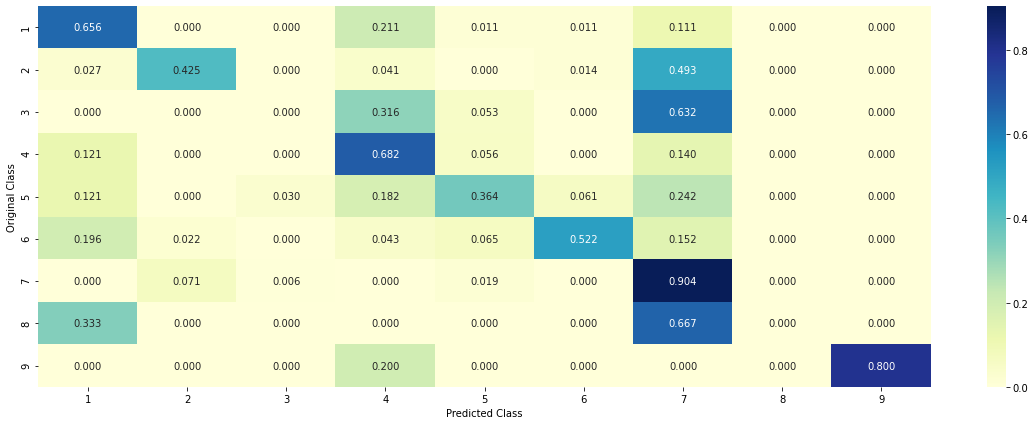

In [0]:
clf = SGDClassifier( alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusionmatrix(X_Train_onehotcoding_bigram, Y_Train, X_CV_onehotcoding_bigram, Y_CV, clf)

# CONCLUSION

In [0]:
pip install -U PTable

  Created wheel for PTable: filename=PTable-0.9.2-cp36-none-any.whl size=22908 sha256=7af63c673a4523e8523aa4f73012d7978e3cad3731e2fe4bcc400cad4b7032c3
  Stored in directory: /root/.cache/pip/wheels/22/cc/2e/55980bfe86393df3e9896146a01f6802978d09d7ebcba5ea56
Successfully built PTable


In [58]:
from prettytable import PrettyTable
x= PrettyTable()
x.title = "TF-IDF Featurization"
x.field_names = ["Algorithm" , "Train loss", "CV(Log Loss)", "Test loss","%age of MissClassification"]
x.add_row(["Naive Bayes",0.81,1.24,1.21,"42.00%"])
x.add_row(["K-NN",0.97,1.26,1.28,"43.23%"])
x.add_row(["Logistic Regression(With Class Balancing)",0.36,1.05,1.05,"34.39%"])
x.add_row(["Logistic Regression(Without Class Balancing)",0.35,1.08,1.06,"35.33%"])
x.add_row(["Linear SVM",0.67,1.20,1.22,"40.03%"])
x.add_row(["Stacking Model",0.58,1.19,1.23,"39.84%"])
print(x)
y= PrettyTable()
y.title = "CountVectorizer BIGRAM"
y.field_names = ["Algorithm" , "Train loss", "CV(Log Loss)", "Test loss","%age of MissClassification"]
y.add_row(["Linear Regression(With Class Balancing)",0.68,1.16,1.19,"35.33%"])
y.add_row(["Linear Regression(Without Class Balancing)",0.63,1.19,1.19,"35.33%"])
print(y)

+----------------------------------------------+------------+--------------+-----------+----------------------------+
|                  Algorithm                   | Train loss | CV(Log Loss) | Test loss | %age of MissClassification |
+----------------------------------------------+------------+--------------+-----------+----------------------------+
|                 Naive Bayes                  |    0.81    |     1.24     |    1.21   |           42.00%           |
|                     K-NN                     |    0.97    |     1.26     |    1.28   |           43.23%           |
|  Logistic Regression(With Class Balancing)   |    0.36    |     1.05     |    1.05   |           34.39%           |
| Logistic Regression(Without Class Balancing) |    0.35    |     1.08     |    1.06   |           35.33%           |
|                  Linear SVM                  |    0.67    |     1.2      |    1.22   |           40.03%           |
|                Stacking Model                |    0.58

### BY LOOKING AT THE PREETY TABLE , LOOKS LIKE TF-IDF FEATURIZATION USING LOGISTIC REGRESSION(WITHOUT CLASS BALANCING) WORKS WELL HAVING 0.36 TRAINING LOSS AND 34.39% MISS CLASSIFICATION POINTS. 
### TEST LOSS = 1.05 